# Imports

In [1]:
import os
import sys
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from decimal import Decimal
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *

np.random.seed(1234)
plt.style.use('default')
pd.set_option('display.max_columns', None)

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


# Quick Links

<ol>
    <li><a href=#effect_table>Effect Alleles Table</a></li>
    <li><a href=#effect_viz>Effect Alleles Visual</a></li>
    <li><a href=#noneffect_table>Non-Effect Alleles Table</a></li>
    <li><a href=#noneffect_viz>Non-Effect Alleles Visual</a></li>
</ol>

# Cluster 13

In [2]:
cluster = '13'

## Prepare Effect and Non-Effect Scores

In [3]:
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print("Num effect sequences:", len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster'+cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster'+cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'+cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'+cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)

Num effect sequences: 304
Num noneffect sequences: 304


## Prepare DataFrame

In [4]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'+cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snps_final/ld_buddies_table_stage3.tsv', sep='\t')
effect_score = []
noneffect_score = []
effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
allele_ratio = []
allele_diff = []
effect_rank = []
noneffect_rank = []
ism_score = []
delta_score = []
idr_peak = []
all_gwas = []
coloc = []
for index,row in snps.iterrows():
    effect_score.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][400:600]])))
    noneffect_score.append(np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][400:600]])))
    effect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])))
    noneffect_center.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])))
    effect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_effect_scores[index][400:600]])))
    noneffect_ratio.append(np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][475:525]])) / np.sum(np.array([max(0, np.sum(j)) for j in merged_noneffect_scores[index][400:600]])))
    allele_ratio.append(effect_center[-1] / (noneffect_center[-1] + 0.00001))
    #allele_diff.append(effect_center[-1] - noneffect_center[-1])
    allele_diff.append(np.sum(np.array([np.sum(j) for j in merged_effect_scores[index][475:525]])) - np.sum(np.array([np.sum(j) for j in merged_noneffect_scores[index][475:525]])))
    effect_rank.append((effect_center[-1] / (noneffect_center[-1] + 0.00001)) * effect_ratio[-1])
    noneffect_rank.append((noneffect_center[-1] / (effect_center[-1] + 0.00001)) * noneffect_ratio[-1])
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        gwas_list.append(rw['source_gwas']+': '+str('%.2E' % Decimal(rw['pvalue'])))
        if rw['has_coloc'] == True:
            has_coloc = True
    all_gwas.append(gwas_list)
    coloc.append(has_coloc)
snps['effect_score'] = effect_score
snps['noneffect_score'] = noneffect_score
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['allele_ratio'] = allele_ratio
snps['allele_diff'] = allele_diff
snps['effect_rank'] = effect_rank
snps['noneffect_rank'] = noneffect_rank
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['idr_peak'] = idr_peak
snps['all_gwas'] = all_gwas
snps['coloc'] = coloc
snps.sort_values(by=['allele_ratio'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)

## Find Effect Alleles that Break Accessibility <a name='effect_table' />

In [5]:
neg_snps = snps.loc[snps['allele_ratio'] <= 1]
neg_snps.sort_values(by=['noneffect_rank'], ascending=False, inplace=True)
display(neg_snps)

chr      start        end         rsid effect noneffect ref    alt  \
278   chr4   89836583   89836584    rs2619361      C         A   C      A   
199  chr19   45326535   45326536     rs344791      C         G   G      C   
230   chr3   49007333   49007334    rs6781790      T         C   C      T   
243   chr3   52771464   52771465  rs147131488      T         G   G    A,T   
267   chr4   89829436   89829437    rs2583979      T         A   A      T   
98   chr17   45947195   45947196   rs62062785      T         G   G    A,T   
144  chr19   44747898   44747899    rs2965169      C         A   A      C   
64   chr17    4901871    4901872   rs79436576      T         C   C      T   
170  chr19   44943903   44943904       rs5157      T         C   T      C   
262   chr4   89761651   89761652     rs356196    NAN       NAN   A    C,T   
198  chr19   45326123   45326124     rs344792      A         G   G      A   
235   chr3   52288193   52288194  rs146664705      G         C   C    A,G   
289   chr7   23116459   23116460    rs1558313      A         G   G      A   
279   chr5  103120549  103120550      rs26523      T         C   C      T   
247   chr4     872934     872935   rs62297061    NAN       NAN   C      T   
156  chr19   44890258   44890259  rs117310449      T         C   C      T   
88   chr17   45894418   45894419   rs11575895      G         A   A      G   
57   chr16   31117346   31117347   rs12716982      C         A   C      A   
141  chr19   44718494   44718495   rs79638902      T         C   T      C   
90   chr17   45894775   45894776   rs11575896      G         A   G      A   
284   chr6   27772520   27772521     rs760587      C         A   C      A   
213   chr2  127107344  127107345   rs76516995      C         G   C    A,G   
27   chr11   86103987   86103988    rs1237999      A         G   G      A   
0     chr1  171699672  171699673   rs12127026      G         A   A      G   
116  chr17   46143983   46143984    rs2532307      A         G   G    A,C   
49   chr16   30922753   30922754    rs3813020      G         A   G      A   
62   chr17    4858739    4858740   rs16954223      A         C   A      C   
180  chr19   44954954   44954955  rs117316645      A         G   G    A,C   
283   chr6   27754284   27754285    rs4713121      T         C   T      C   
154  chr19   44846144   44846145    rs3810143      C         T   T    C,G   
..     ...        ...        ...          ...    ...       ...  ..    ...   
240   chr3   52420251   52420252  rs151068971      G         A   A      G   
76   chr17   45826118   45826119   rs62057148      G         C   G    A,C   
208   chr2  127084192  127084193   rs10200967      T         C   C      T   
183  chr19   44955205   44955206    rs8102895      A         G   A      G   
270   chr4   89829570   89829571    rs2737004      G         A   A      G   
152  chr19   44845919   44845920   rs77241309      C         G   G      C   
251   chr4     987107     987108   rs11248061      C         A   C      A   
280   chr5  103120599  103120600      rs26524      G         A   A      G   
217   chr2  127107523  127107524   rs13032148      A         G   G      A   
65   chr17    4902093    4902094   rs72835059      A         G   G      A   
132  chr17   78432504   78432505  17_78432505      G         A   .      .   
83   chr17   45849620   45849621    rs8068916      T         G   T    C,G   
272   chr4   89829692   89829693    rs2619356    NAN       NAN   C      T   
87   chr17   45894237   45894238   rs62056778      G         C   C      G   
219   chr2  127118665  127118666   rs71414738      T         C   C      T   
146  chr19   44800770   44800771  rs139246905      C         T   T    A,C   
101  chr17   45949128   45949129   rs74531363      G         A   A    G,T   
218   chr2  127107527  127107528  2_127107528    NAN       NAN   .      .   
114  chr17   46130777   46130778   rs17661428      C         G   C      G   
178  chr19   44954888   44954889    rs3760629      A         C   A      C   
69 

## Visualize Top Effect Alleles <a name='effect_viz' />

RSID: rs2619361   ||    chr4 : 89836583 - 89836584   ||    Locus: 278   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  2.97E-07
23andme_PD_hg38 		  1.36E-08

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.25   ||   Center / 200bp : 0.271
Noneffect Sequence : GTCTCTTTCATTAGGCTCCC


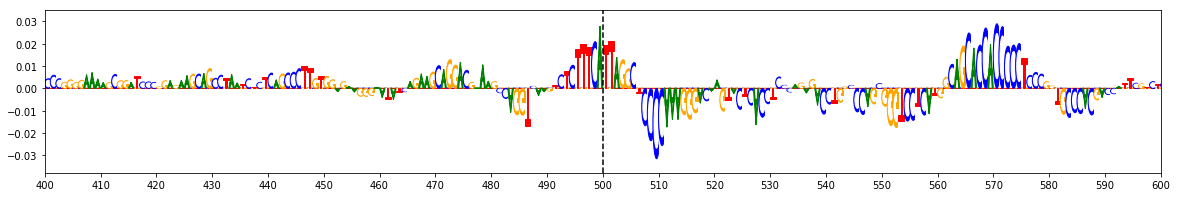

Effect Allele : C   ||   Explain Score : 0.0444   ||   Center / 200bp : 0.0619
Effect Sequence : GTCTCTTTCCTTAGGCTCCC


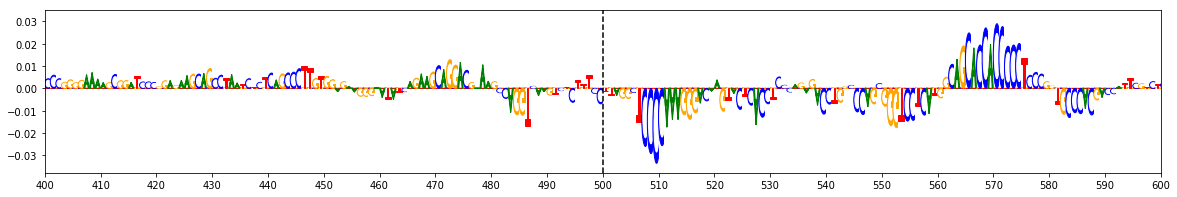

Allele Ratio : 0.1777   ||   Allele Difference : -0.2752  ||  ISM Score : -0.4302  ||  deltaSVM Score : -2.4716


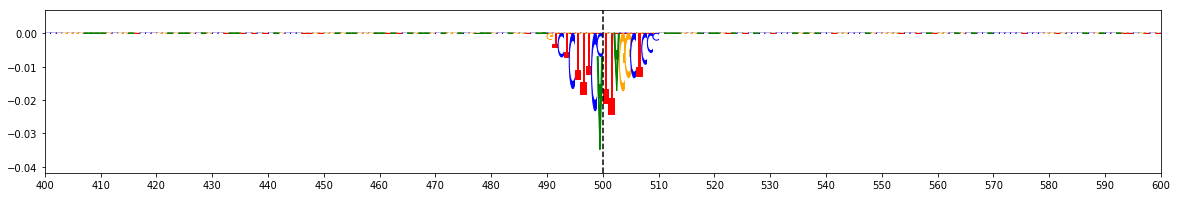


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344791   ||    chr19 : 45326535 - 45326536   ||    Locus: 199   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.22E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.1091   ||   Center / 200bp : 0.3527
Noneffect Sequence : CTCAAGACCGCCTCCACTGT


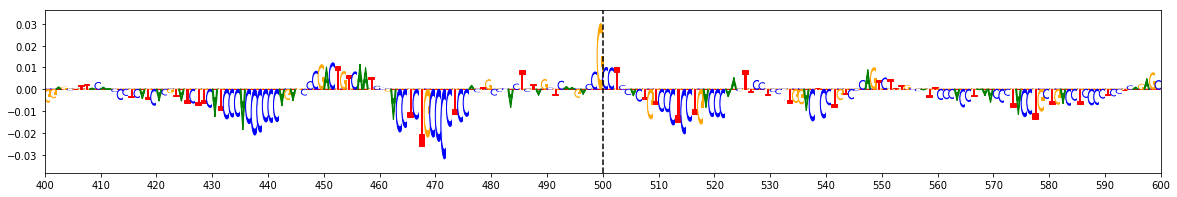

Effect Allele : C   ||   Explain Score : 0.0268   ||   Center / 200bp : 0.1191
Effect Sequence : CTCAAGACCCCCTCCACTGT


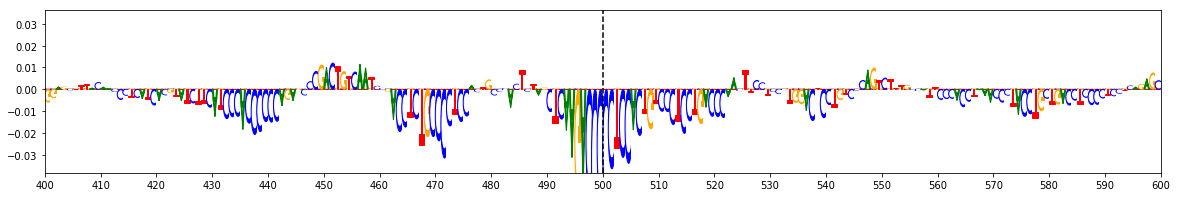

Allele Ratio : 0.2454   ||   Allele Difference : -0.6383  ||  ISM Score : -1.0222  ||  deltaSVM Score : -5.8863


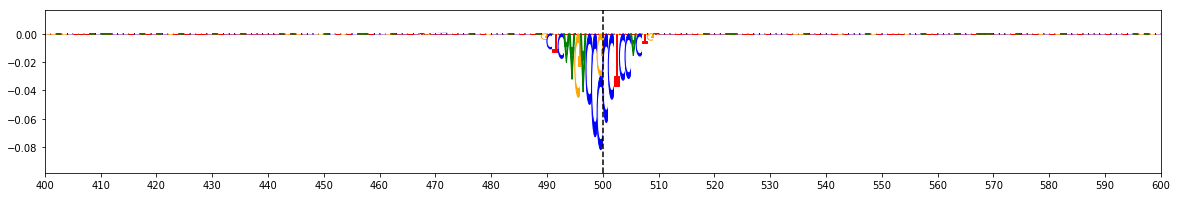


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 230   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.35E-03
Nalls_23andMe 		  2.35E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.9036   ||   Center / 200bp : 0.4204
Noneffect Sequence : AGCTGAGGGCGCTGTTGATG


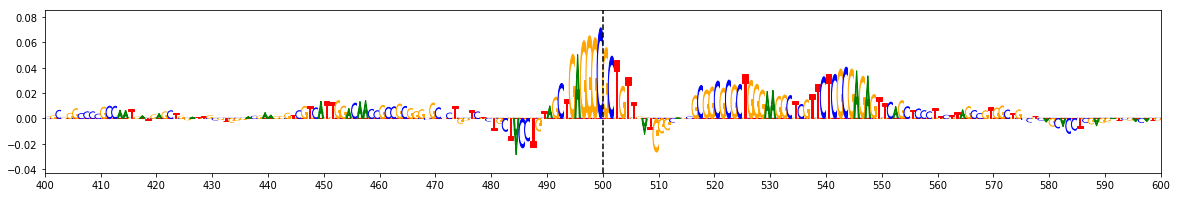

Effect Allele : T   ||   Explain Score : 0.3667   ||   Center / 200bp : 0.2272
Effect Sequence : AGCTGAGGGTGCTGTTGATG


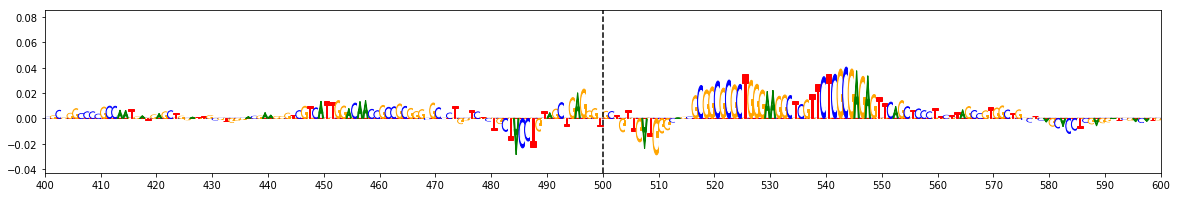

Allele Ratio : 0.4058   ||   Allele Difference : -0.6068  ||  ISM Score : -0.9555  ||  deltaSVM Score : -5.5358


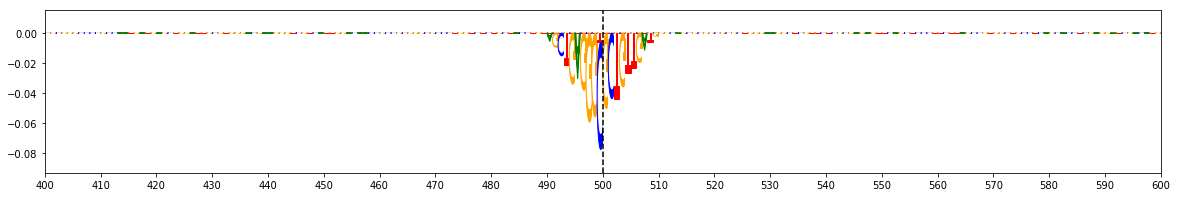


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147131488   ||    chr3 : 52771464 - 52771465   ||    Locus: 243   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  2.00E-03

Coloc:  False

Noneffect Allele : G   ||   Explain Score : 0.337   ||   Center / 200bp : 0.2882
Noneffect Sequence : GCACTAAGAGACTTGACTAA


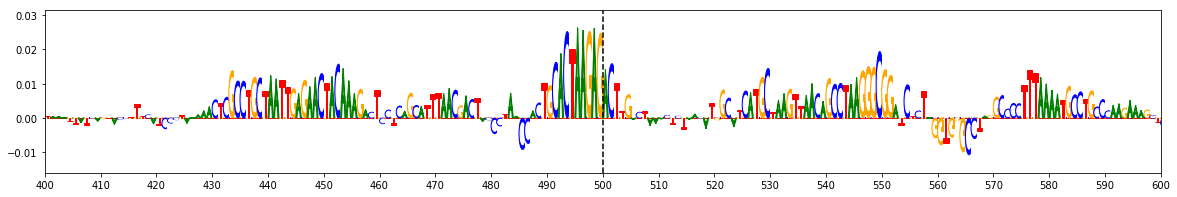

Effect Allele : T   ||   Explain Score : 0.0978   ||   Center / 200bp : 0.1052
Effect Sequence : GCACTAAGATACTTGACTAA


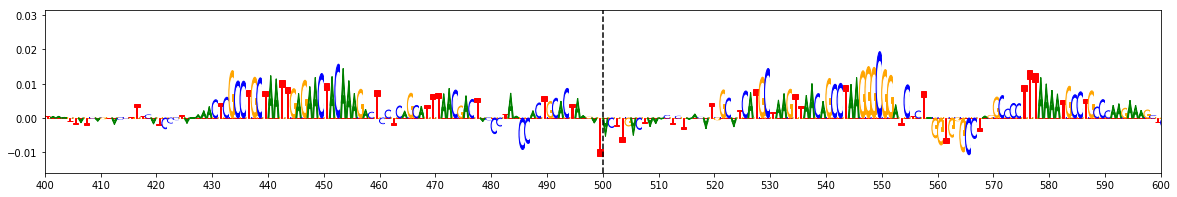

Allele Ratio : 0.2903   ||   Allele Difference : -0.2812  ||  ISM Score : -0.4444  ||  deltaSVM Score : -2.5757


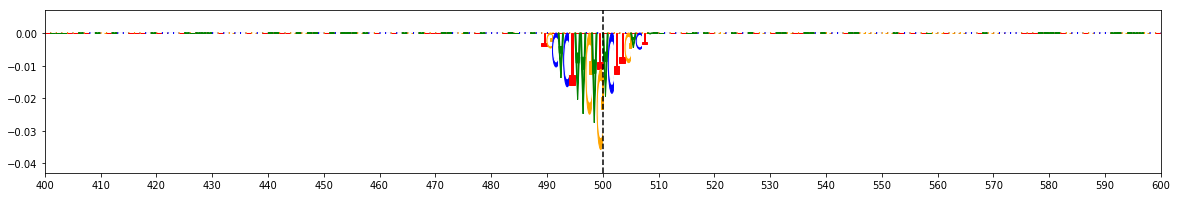


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2583979   ||    chr4 : 89829436 - 89829437   ||    Locus: 267   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  3.63E-14

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4237   ||   Center / 200bp : 0.5855
Noneffect Sequence : TTTTCAGCAACACTTCCTCT


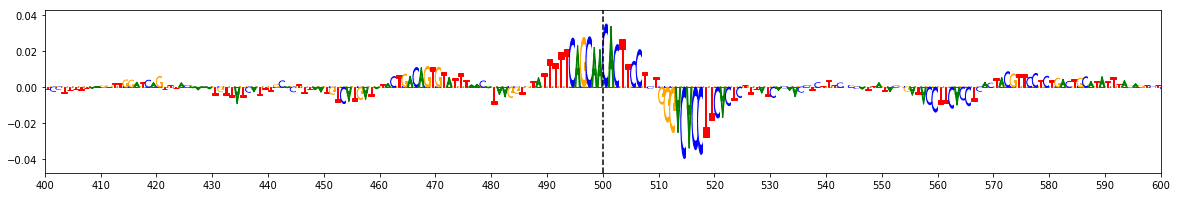

Effect Allele : T   ||   Explain Score : 0.2602   ||   Center / 200bp : 0.4651
Effect Sequence : TTTTCAGCATCACTTCCTCT


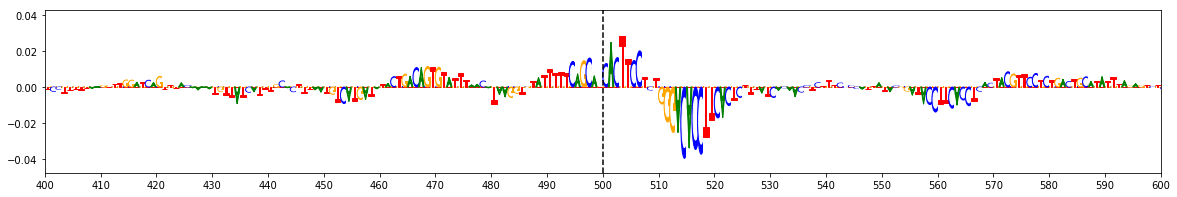

Allele Ratio : 0.6142   ||   Allele Difference : -0.1637  ||  ISM Score : -0.2578  ||  deltaSVM Score : -1.5126


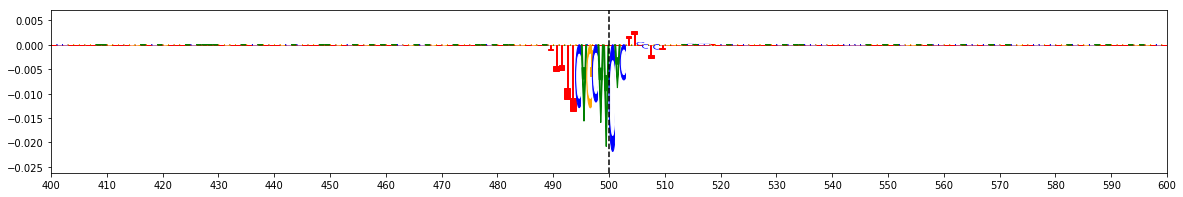


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062785   ||    chr17 : 45947195 - 45947196   ||    Locus: 98   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  3.33E-22

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.7873   ||   Center / 200bp : 0.5714
Noneffect Sequence : CTCCCAGTGGCTGCCTGTGT


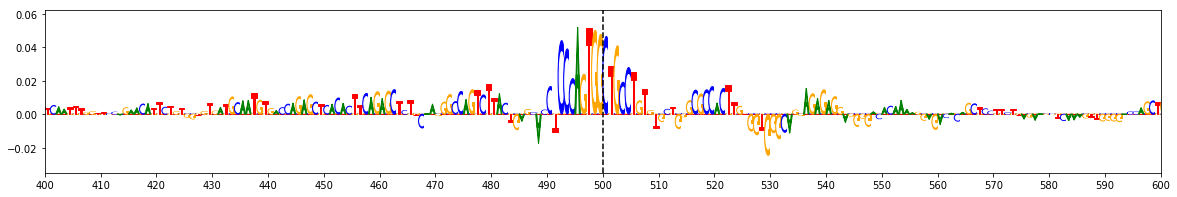

Effect Allele : T   ||   Explain Score : 0.4925   ||   Center / 200bp : 0.4548
Effect Sequence : CTCCCAGTGTCTGCCTGTGT


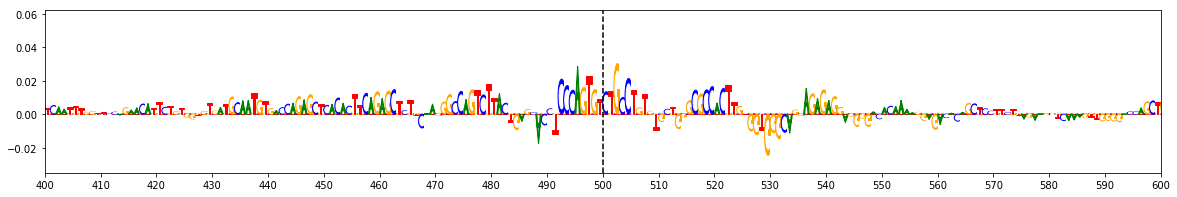

Allele Ratio : 0.6255   ||   Allele Difference : -0.3036  ||  ISM Score : -0.4752  ||  deltaSVM Score : -2.7763


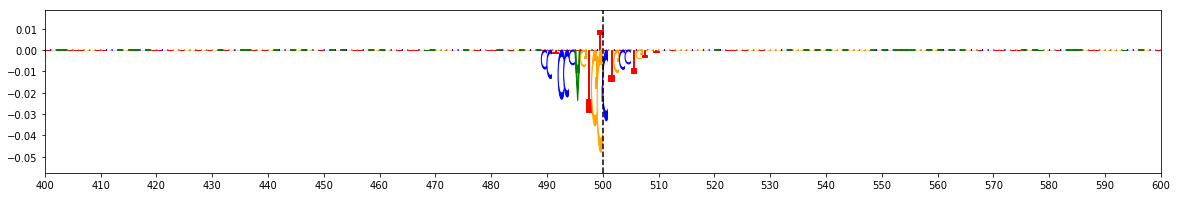


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2965169   ||    chr19 : 44747898 - 44747899   ||    Locus: 144   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.13E-57
Alzheimers_Kunkle_2019 		  2.75E-37
Alzheimers_Lambert_2013 	  5.18E-36

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4784   ||   Center / 200bp : 0.79
Noneffect Sequence : CCCCCAACGAGTGCAGAGAC


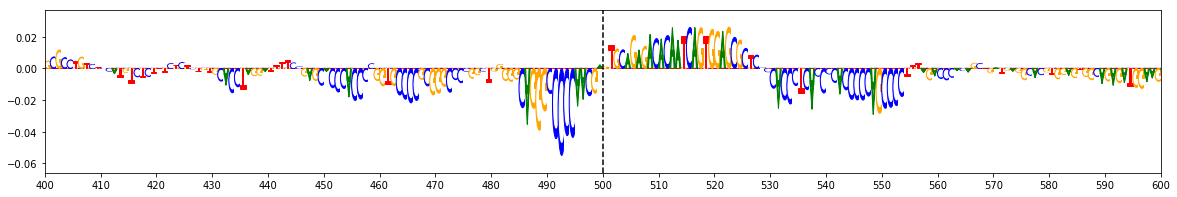

Effect Allele : C   ||   Explain Score : 0.4149   ||   Center / 200bp : 0.7653
Effect Sequence : CCCCCAACGCGTGCAGAGAC


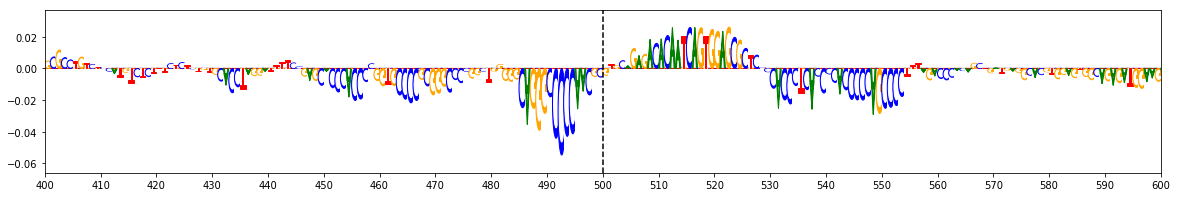

Allele Ratio : 0.8672   ||   Allele Difference : -0.0603  ||  ISM Score : -0.0967  ||  deltaSVM Score : -0.5556


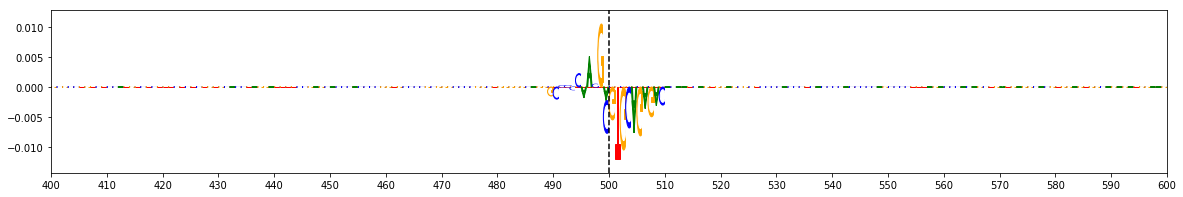


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79436576   ||    chr17 : 4901871 - 4901872   ||    Locus: 64   ||    IDR Peak: False

GWAS:
Alzheimers_Kunkle_2019 		  3.06E-04
Alzheimers_Lambert_2013 	  4.79E-05

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 1.4567   ||   Center / 200bp : 0.4762
Noneffect Sequence : CGGTTGGCCCCGCCCCATAA


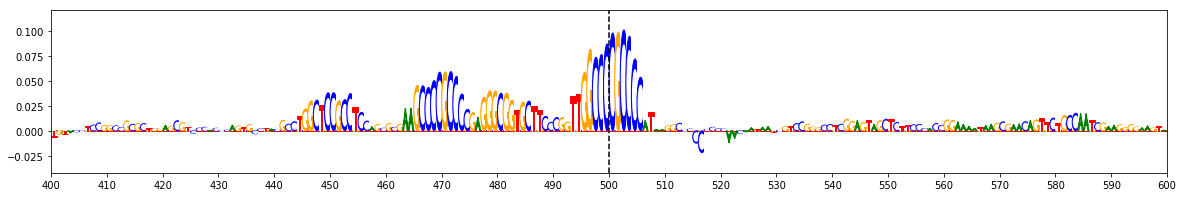

Effect Allele : T   ||   Explain Score : 0.7649   ||   Center / 200bp : 0.3204
Effect Sequence : CGGTTGGCCTCGCCCCATAA


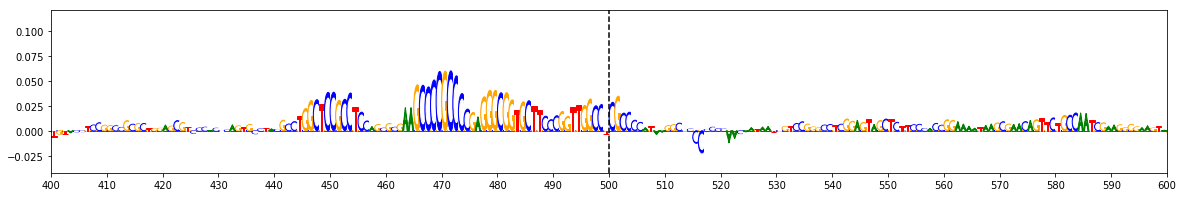

Allele Ratio : 0.5251   ||   Allele Difference : -0.7017  ||  ISM Score : -1.0976  ||  deltaSVM Score : -6.4598


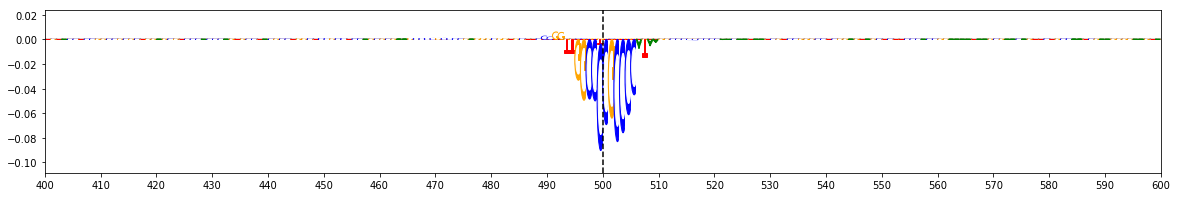


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs5157   ||    chr19 : 44943903 - 44943904   ||    Locus: 170   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  6.84E-05
Alzheimers_Kunkle_2019 		  6.67E-10
Alzheimers_Lambert_2013 	  5.40E-11

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.6879   ||   Center / 200bp : 0.5317
Noneffect Sequence : GCACACAGCCAGCTACATGT


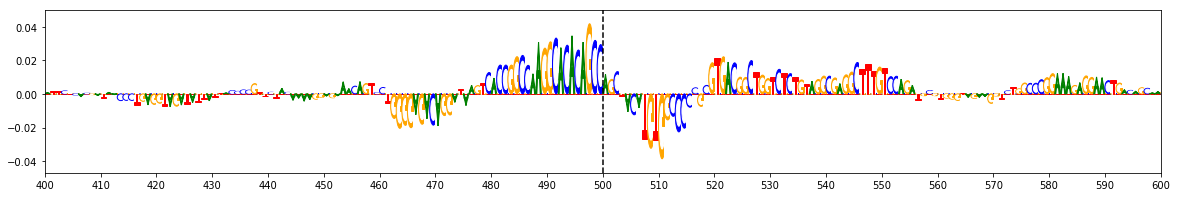

Effect Allele : T   ||   Explain Score : 0.446   ||   Center / 200bp : 0.4245
Effect Sequence : GCACACAGCTAGCTACATGT


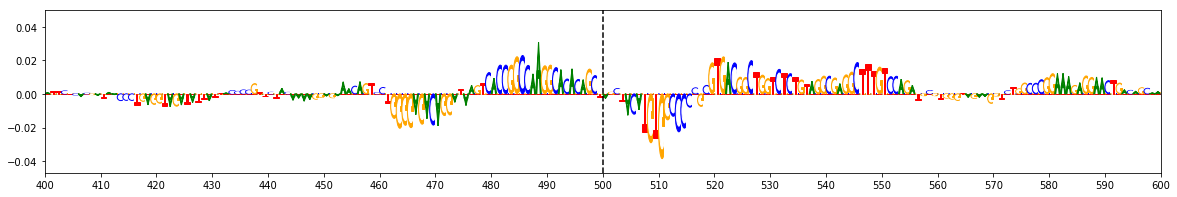

Allele Ratio : 0.6484   ||   Allele Difference : -0.2436  ||  ISM Score : -0.3791  ||  deltaSVM Score : -2.2173


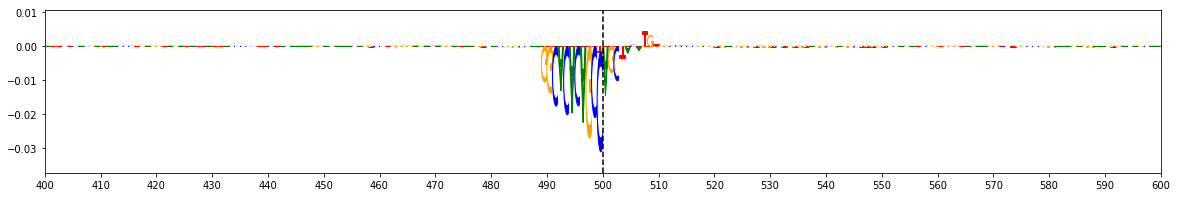


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs356196   ||    chr4 : 89761651 - 89761652   ||    Locus: 262   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  NAN
23andme_PD_hg38 		  9.71E-13

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.725   ||   Center / 200bp : 0.6964
Noneffect Sequence : CTGTACTATAGGGCCACTGT


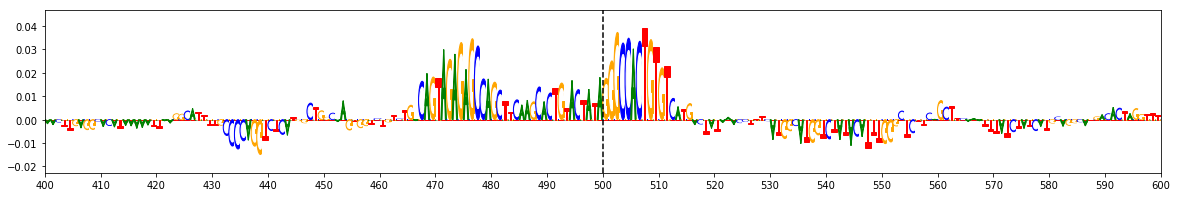

Effect Allele : NAN   ||   Explain Score : 0.6292   ||   Center / 200bp : 0.6656
Effect Sequence : CTGTACTATCGGGCCACTGT


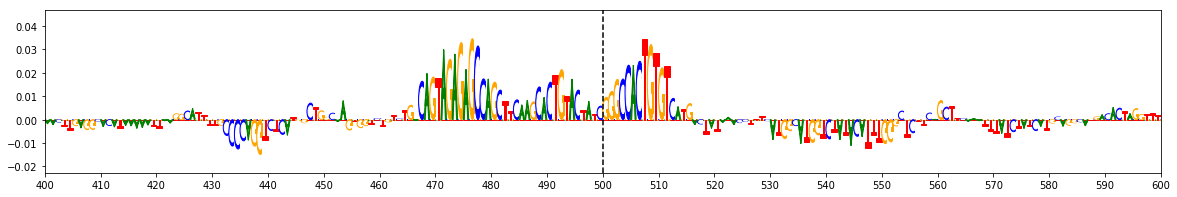

Allele Ratio : 0.8679   ||   Allele Difference : -0.0958  ||  ISM Score : -0.1496  ||  deltaSVM Score : -0.8332


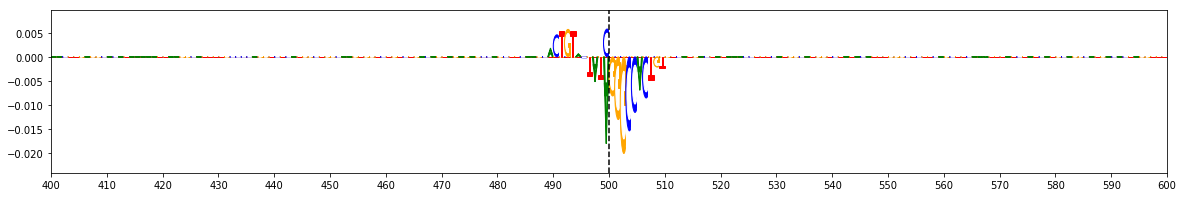


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs344792   ||    chr19 : 45326123 - 45326124   ||    Locus: 198   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.52E-04

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.2682   ||   Center / 200bp : 0.4458
Noneffect Sequence : CTAGTCTCAGACTCCTACCT


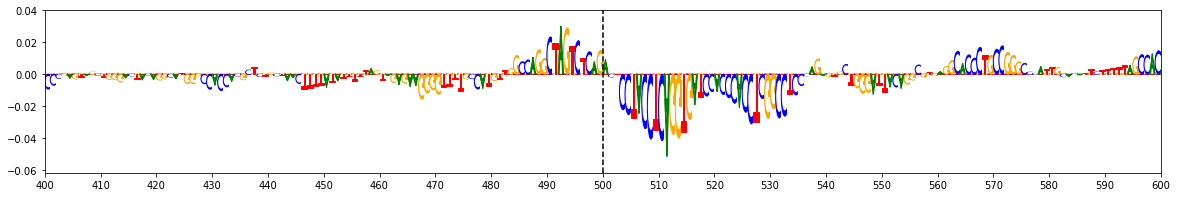

Effect Allele : A   ||   Explain Score : 0.1496   ||   Center / 200bp : 0.3091
Effect Sequence : CTAGTCTCAAACTCCTACCT


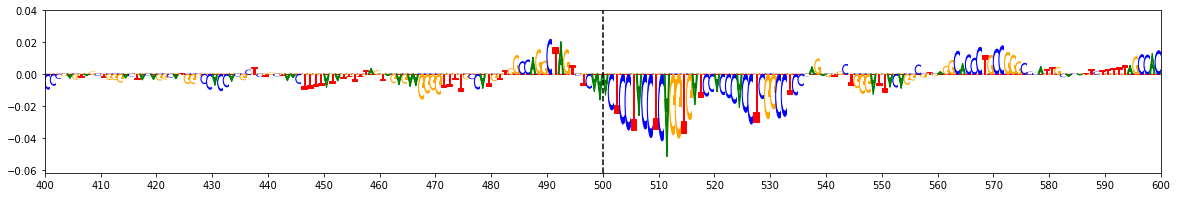

Allele Ratio : 0.5579   ||   Allele Difference : -0.2467  ||  ISM Score : -0.3905  ||  deltaSVM Score : -2.1517


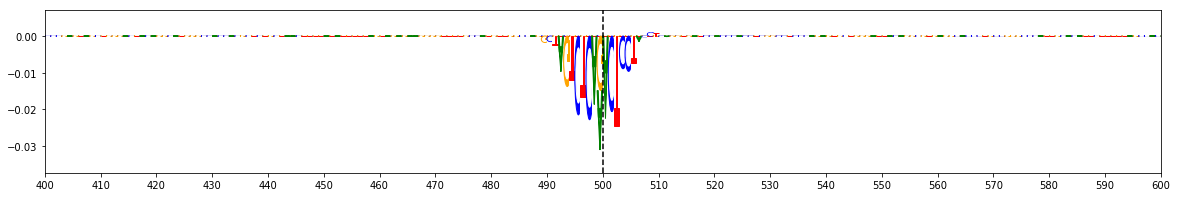


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs146664705   ||    chr3 : 52288193 - 52288194   ||    Locus: 235   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.04E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.5131   ||   Center / 200bp : 0.54
Noneffect Sequence : AGGACTTAGCAAATAAAAAT


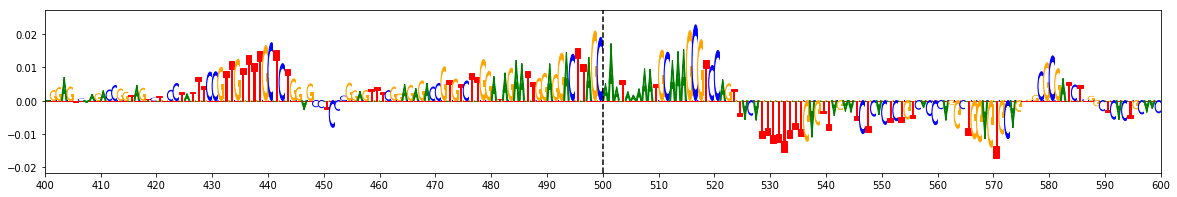

Effect Allele : G   ||   Explain Score : 0.3491   ||   Center / 200bp : 0.4441
Effect Sequence : AGGACTTAGGAAATAAAAAT


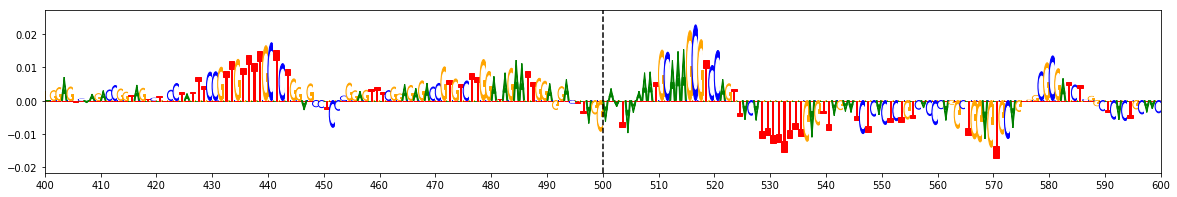

Allele Ratio : 0.6805   ||   Allele Difference : -0.2218  ||  ISM Score : -0.3463  ||  deltaSVM Score : -2.0037


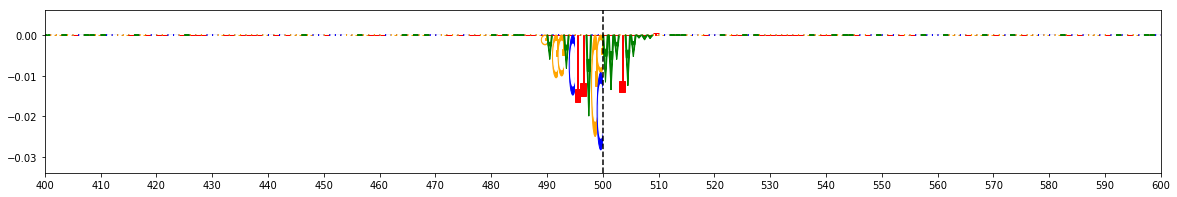


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs1558313   ||    chr7 : 23116459 - 23116460   ||    Locus: 289   ||    IDR Peak: False

GWAS:
Parkinsons_Pankratz_2012 	  2.42E-03

Coloc:  True

Noneffect Allele : G   ||   Explain Score : 0.6479   ||   Center / 200bp : 0.583
Noneffect Sequence : TTTTCCTCTGTGGTACATCT


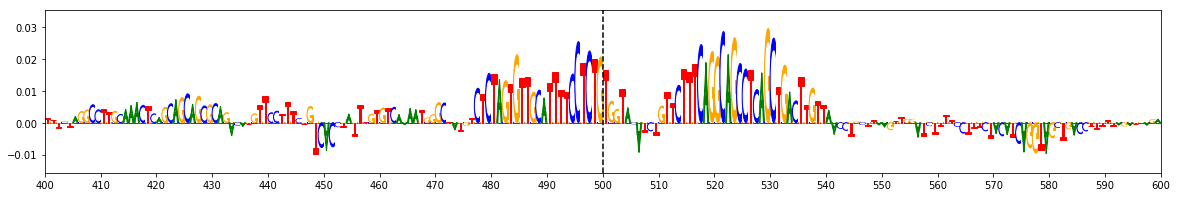

Effect Allele : A   ||   Explain Score : 0.4831   ||   Center / 200bp : 0.5104
Effect Sequence : TTTTCCTCTATGGTACATCT


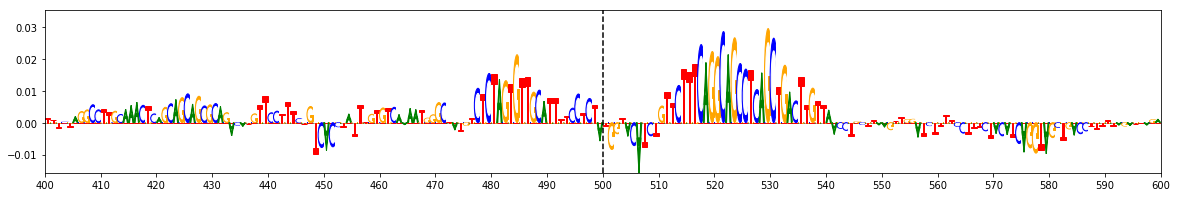

Allele Ratio : 0.7456   ||   Allele Difference : -0.2078  ||  ISM Score : -0.3263  ||  deltaSVM Score : -1.8873


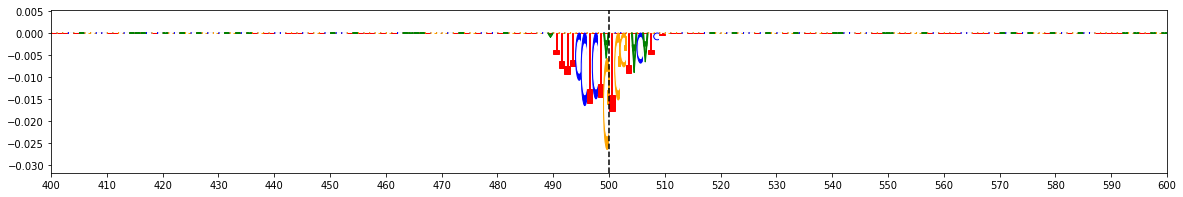


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs26523   ||    chr5 : 103120549 - 103120550   ||    Locus: 279   ||    IDR Peak: True

GWAS:
Nalls_23andMe 		  1.08E-03

Coloc:  False

Noneffect Allele : C   ||   Explain Score : 0.3991   ||   Center / 200bp : 0.4287
Noneffect Sequence : GGGTTGAGGCGGCTGCTGGG


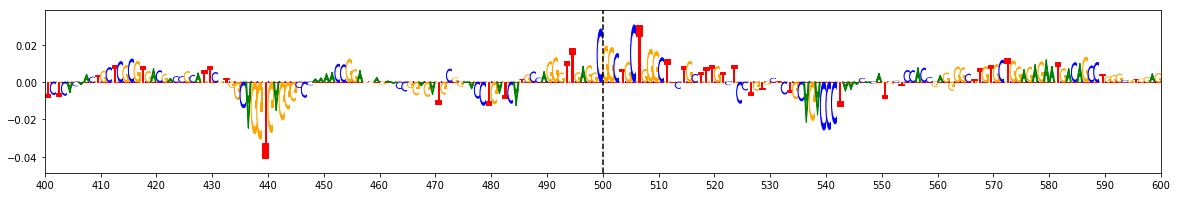

Effect Allele : T   ||   Explain Score : 0.2193   ||   Center / 200bp : 0.2921
Effect Sequence : GGGTTGAGGTGGCTGCTGGG


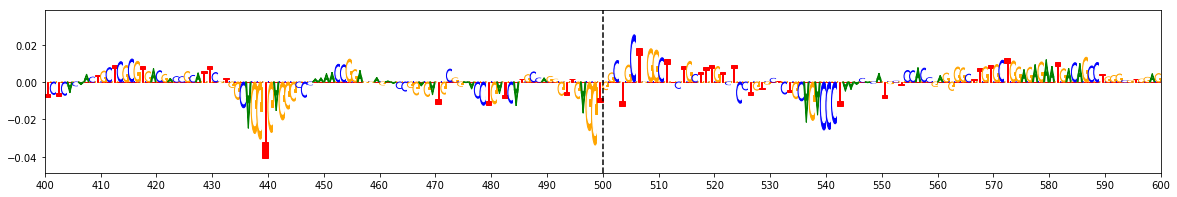

Allele Ratio : 0.5495   ||   Allele Difference : -0.3064  ||  ISM Score : -0.479  ||  deltaSVM Score : -2.7747


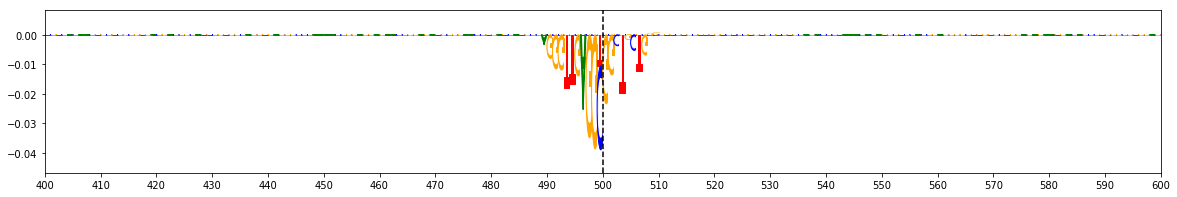


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62297061   ||    chr4 : 872934 - 872935   ||    Locus: 247   ||    IDR Peak: True

GWAS:
Parkinsons_Pankratz_2012 	  NAN

Coloc:  True

Noneffect Allele : NAN   ||   Explain Score : 0.3687   ||   Center / 200bp : 0.3389
Noneffect Sequence : CAGGCACGGCGCAGGCTCAC


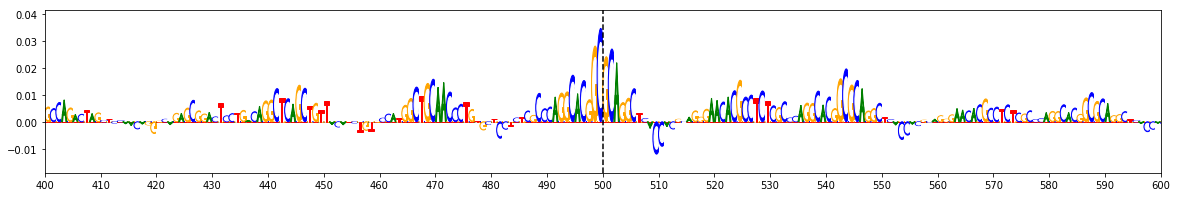

Effect Allele : NAN   ||   Explain Score : 0.1613   ||   Center / 200bp : 0.1762
Effect Sequence : CAGGCACGGTGCAGGCTCAC


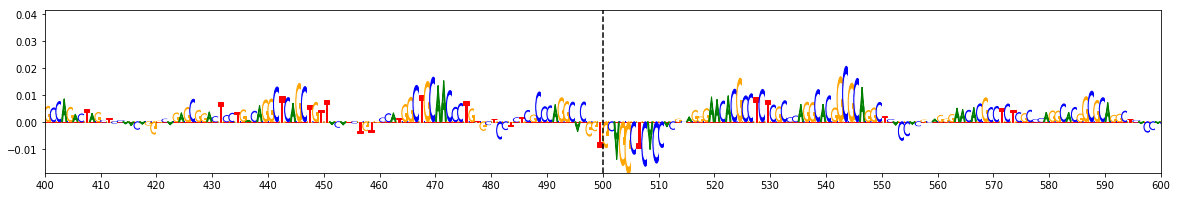

Allele Ratio : 0.4374   ||   Allele Difference : -0.3428  ||  ISM Score : -0.7537  ||  deltaSVM Score : -4.3317


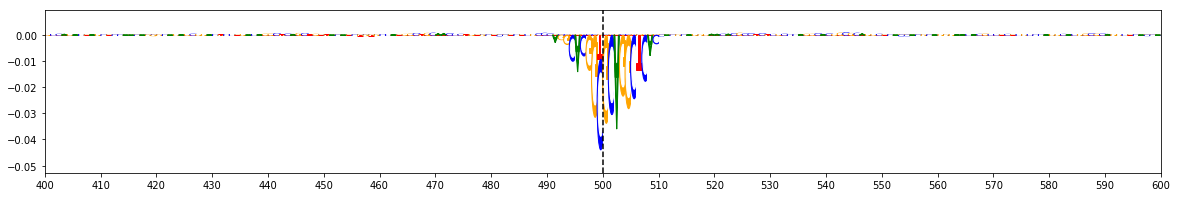


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs117310449   ||    chr19 : 44890258 - 44890259   ||    Locus: 156   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  7.04E-94
Alzheimers_Kunkle_2019 		  2.28E-46
Alzheimers_Lambert_2013 	  3.69E-36

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.2808   ||   Center / 200bp : 0.5384
Noneffect Sequence : GGCCAGAGGCAGAGTGATGA


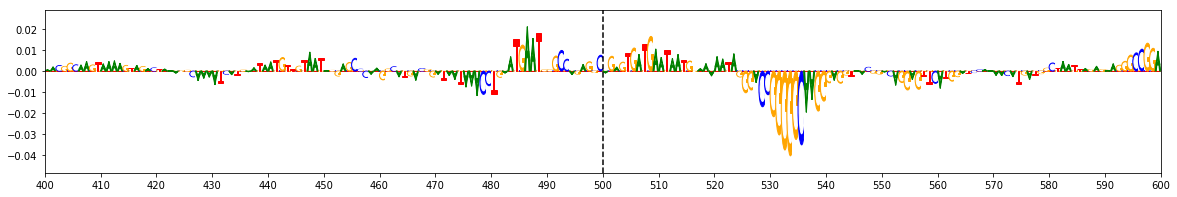

Effect Allele : T   ||   Explain Score : 0.1998   ||   Center / 200bp : 0.4531
Effect Sequence : GGCCAGAGGTAGAGTGATGA


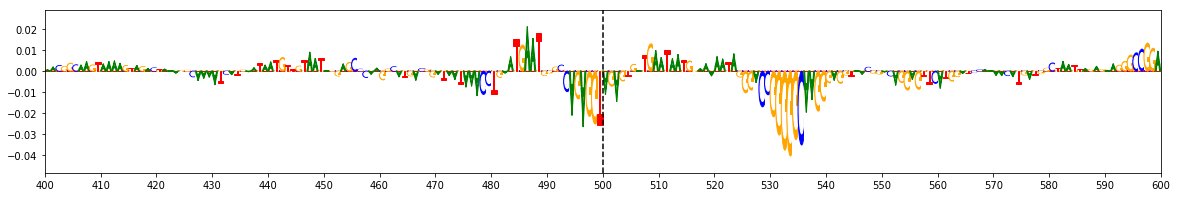

Allele Ratio : 0.7115   ||   Allele Difference : -0.263  ||  ISM Score : -0.4176  ||  deltaSVM Score : -2.4131


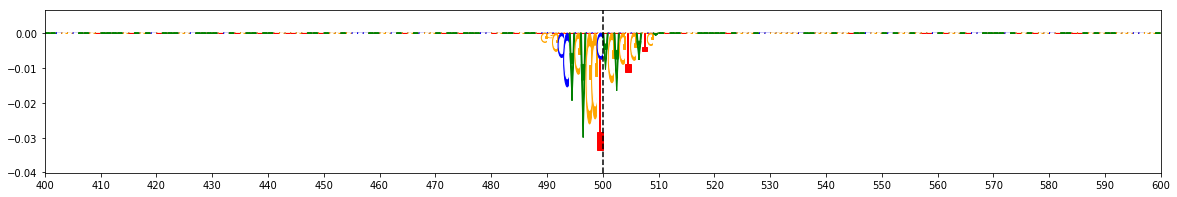


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575895   ||    chr17 : 45894418 - 45894419   ||    Locus: 88   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 2.2767   ||   Center / 200bp : 0.684
Noneffect Sequence : GCGCCCACTAGTGGCCGGAG


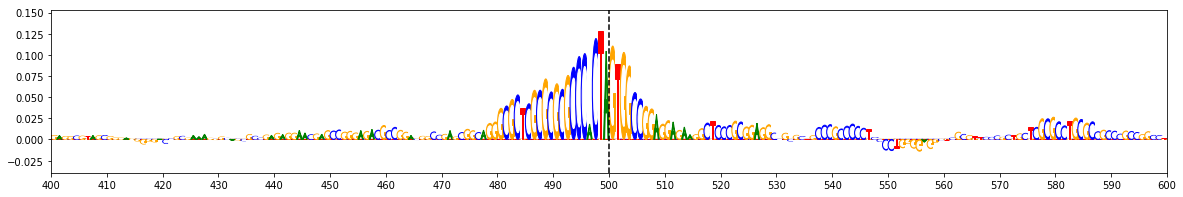

Effect Allele : G   ||   Explain Score : 2.0839   ||   Center / 200bp : 0.6625
Effect Sequence : GCGCCCACTGGTGGCCGGAG


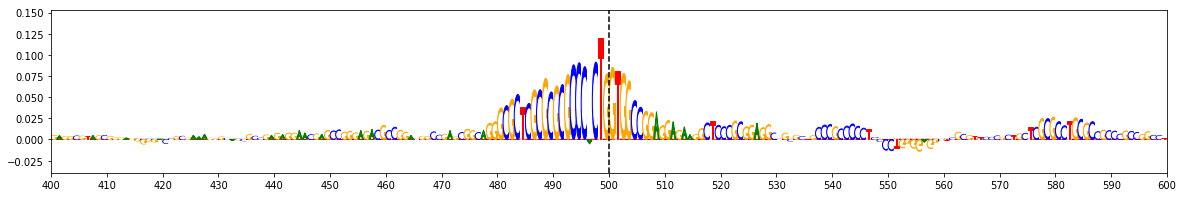

Allele Ratio : 0.9153   ||   Allele Difference : -0.1983  ||  ISM Score : -0.2699  ||  deltaSVM Score : -2.0557


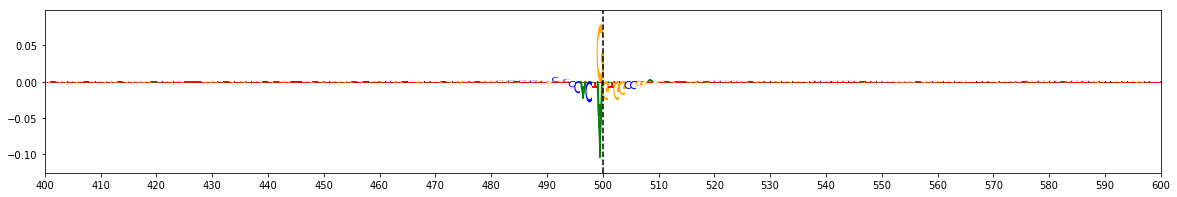


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12716982   ||    chr16 : 31117346 - 31117347   ||    Locus: 57   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.40E-02

Coloc:  False

Noneffect Allele : A   ||   Explain Score : 0.3407   ||   Center / 200bp : 0.5443
Noneffect Sequence : CAGCCTGGGAGACAGAGCAT


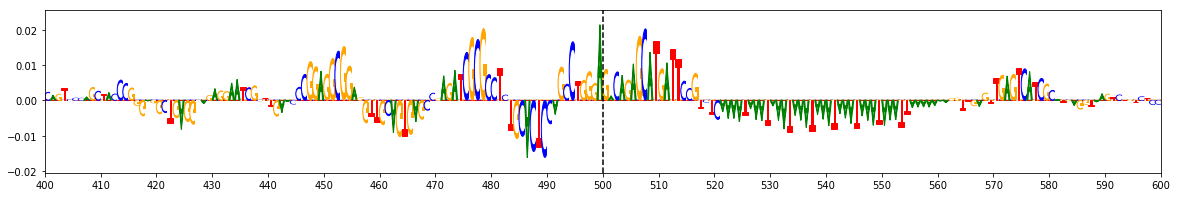

Effect Allele : C   ||   Explain Score : 0.2581   ||   Center / 200bp : 0.4751
Effect Sequence : CAGCCTGGGCGACAGAGCAT


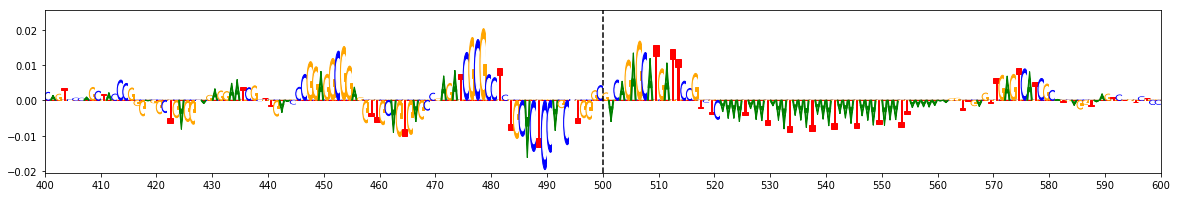

Allele Ratio : 0.7576   ||   Allele Difference : -0.1361  ||  ISM Score : -0.2662  ||  deltaSVM Score : -1.5875


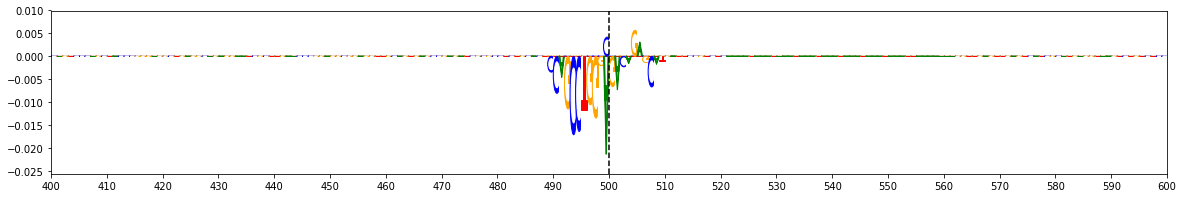


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs79638902   ||    chr19 : 44718494 - 44718495   ||    Locus: 141   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  2.87E-24
Alzheimers_Kunkle_2019 		  1.31E-14
Alzheimers_Lambert_2013 	  1.46E-17

Coloc:  True

Noneffect Allele : C   ||   Explain Score : 0.4749   ||   Center / 200bp : 0.467
Noneffect Sequence : AGGATTTGGCCCAGAGAGGA


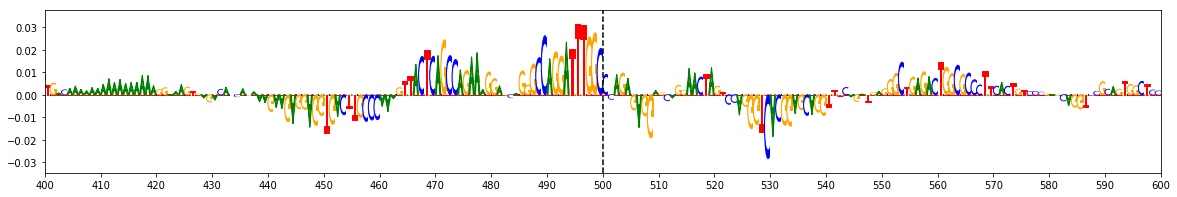

Effect Allele : T   ||   Explain Score : 0.31   ||   Center / 200bp : 0.364
Effect Sequence : AGGATTTGGTCCAGAGAGGA


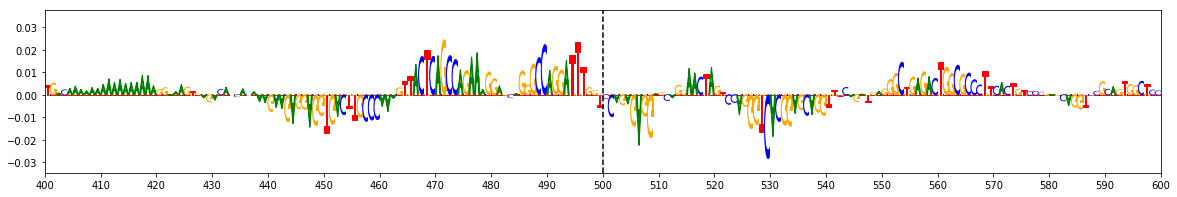

Allele Ratio : 0.6528   ||   Allele Difference : -0.2072  ||  ISM Score : -0.3343  ||  deltaSVM Score : -1.9498


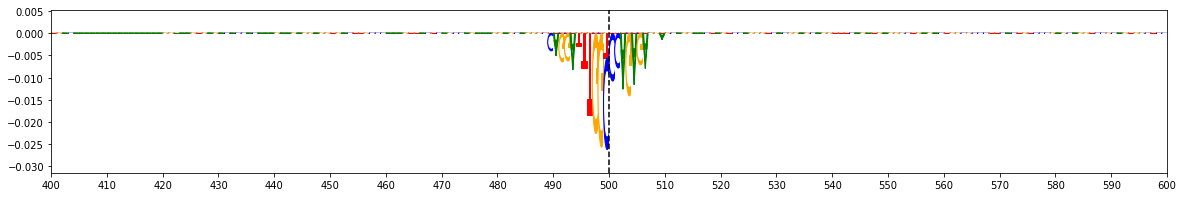


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11575896   ||    chr17 : 45894775 - 45894776   ||    Locus: 90   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.94E-22

Coloc:  True

Noneffect Allele : A   ||   Explain Score : 0.4617   ||   Center / 200bp : 0.638
Noneffect Sequence : GCAGACTGGAGCTTCGTGCG


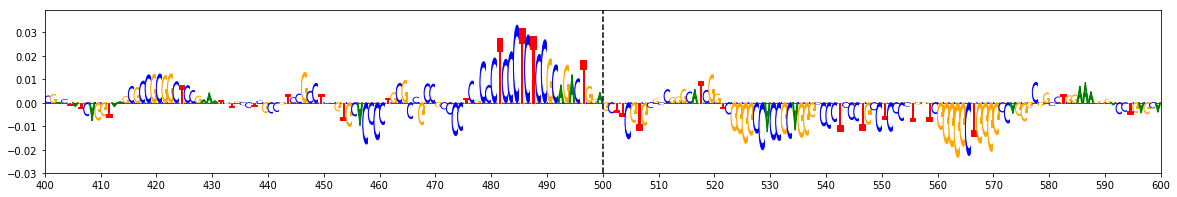

Effect Allele : G   ||   Explain Score : 0.4129   ||   Center / 200bp : 0.612
Effect Sequence : GCAGACTGGGGCTTCGTGCG


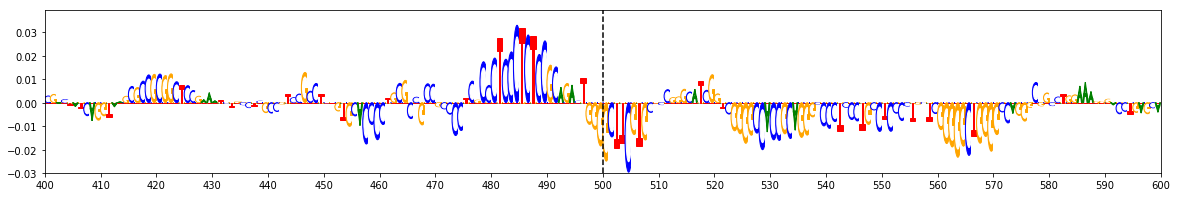

Allele Ratio : 0.8943   ||   Allele Difference : -0.1813  ||  ISM Score : -0.2912  ||  deltaSVM Score : -1.6721


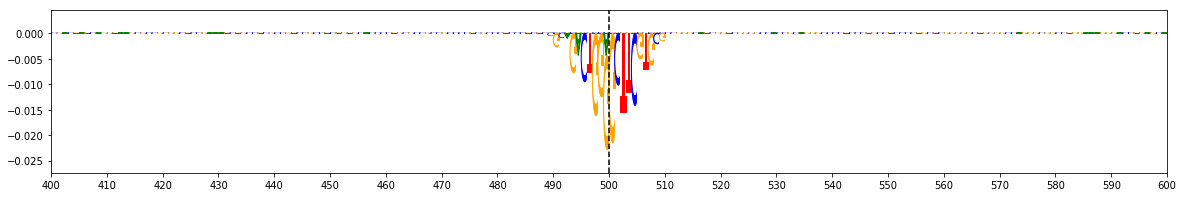


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [6]:
for idx in neg_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], ':', neg_snps.at[idx, 'start'], '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in neg_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
    
    print("Coloc: ", neg_snps.at[idx, 'coloc'])
    
    print()
    
    print('Noneffect Allele :', neg_snps.at[idx, 'noneffect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'noneffect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence :', noneffect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Effect Allele :', neg_snps.at[idx, 'effect'], '  ||   Explain Score :', round(neg_snps.at[idx, 'effect_center'], 4), '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence :', effect_seqs[idx][490:510])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(neg_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(neg_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(neg_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(neg_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()

## Find Non-Effect Alleles that Improve Accessibility <a name='noneffect_table' />

In [7]:
pos_snps = snps.loc[snps['allele_ratio'] > 1]
pos_snps.sort_values(by=['effect_rank'], ascending=False, inplace=True)
display(pos_snps)

chr      start        end         rsid effect noneffect         ref  \
241   chr3   52498433   52498434  rs181391313      G         A           G   
78   chr17   45826181   45826182   rs62057150      T         C           C   
191  chr19   45039212   45039213   rs34034621      T         C           C   
23   chr11   65834088   65834089   rs17854357      C         G           G   
35   chr13   97212766   97212767    rs4771268      T         C           T   
294   chr8   22599691   22599692     rs755934      T         G           T   
94   chr17   45942313   45942314   rs62062770      T         C           T   
6     chr1  232508907  232508908   rs12073680      G         A           A   
161  chr19   44905370   44905371     rs769446      T         C           T   
142  chr19   44723890   44723891  rs150820726      T         A           A   
205   chr2  101762281  101762282    rs2068397      C         A           C   
5     chr1  226737182  226737183  rs147889095      I         D  ACTGCCGCTG   
1     chr1  171699810  171699811   rs10913511      G         A           G   
303   chr9   17578708   17578709    rs3758216      G         C           G   
140  chr19   44644039   44644040   rs11540084      T         G           G   
112  chr17   46073113   46073114     rs974291      T         A           A   
56   chr16   31106091   31106092    rs2032915      T         C           C   
121  chr17   46771150   46771151     rs199523      C         A           C   
221   chr2  134718389  134718390   rs62171393      G         C           C   
165  chr19   44911193   44911194     rs439401      T         C           T   
285   chr6   27772886   27772887    rs9468223      T         C           C   
253   chr4   15735724   15735725    rs4698412      G         A           G   
96   chr17   45942947   45942948   rs62062772      T         C           C   
110  chr17   46004160   46004161   rs62064665      T         C           T   
269   chr4   89829438   89829439    rs2737005    NAN       NAN           A   
197  chr19   45137506   45137507  rs536518226      C         G           G   
203   chr2   95296799   95296800    rs3755525      G         C           C   
25   chr11   86068267   86068268    rs2458500      A         G           A   
212   chr2  127106969  127106970   rs11554586      A         G           G   
26   chr11   86069405   86069406    rs3016327      T         C           T   
..     ...        ...        ...          ...    ...       ...         ...   
302   chr8   27608797   27608798    rs1532278      T         C           T   
166  chr19   44912920   44912921     rs483082    NAN       NAN           G   
237   chr3   52339932   52339933  rs149814394      G         A           G   
192  chr19   45045876   45045877  rs112481437      A         G           G   
11   chr10  119651404  119651405  rs144814361      T         C           C   
73   chr17   45740793   45740794   rs76728632      C         A           A   
85   chr17   45894090   45894091   rs76594404      G         C           G   
80   chr17   45849388   45849389   rs62054820      G         A           A   
9    chr10   80505514   80505515    rs9633740      A         G           A   
149  chr19   44808778   44808779    rs2967671      G         C           C   
249   chr4     973656     973657   rs13137144      G         A           G   
99   chr17   45949111   45949112   rs78556223      G         A           A   
4     chr1  207565781  207565782    rs3886100      A         G           A   
100  chr17   45949123   45949124   rs77266933      C         A           A   
134  chr17   78432578   78432579   rs72907463      G         A           G   
84   chr17   45849625   45849626   rs56269136      T         C           C   
145  chr19   44784591   44784592    rs2927448      T         G           G   
206   chr2  101823703  101823704    rs2286240      G         A           G   
276   chr4   89836353   89836354    rs1372520      T         C           T   
169  chr19   44915228   44915

## Visualize Top Non-Effect Alleles <a name='noneffect_viz' />

RSID: rs181391313   ||    chr3 : 52498433 - 52498434   ||    Locus: 241   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  2.73E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.4438   ||  Center / 200bp: 0.3834
Effect Sequence: CCATGGGGCGGAGGCAGGGC


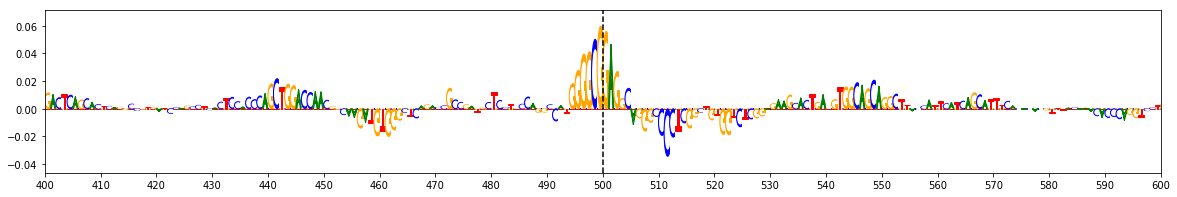

Noneffect Allele: A   ||  Explain Score: 0.0711   ||  Center / 200bp: 0.0906
Noneffect Sequence: CCATGGGGCAGAGGCAGGGC


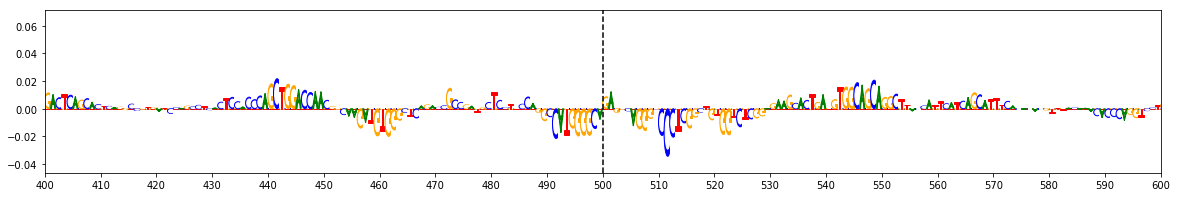

Allele Ratio : 6.2384   ||   Allele Difference : 0.5292  ||  ISM Score : 0.8277  ||  deltaSVM Score : 4.7594


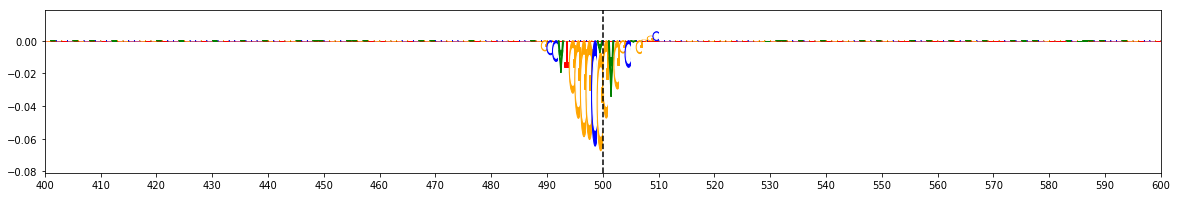


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62057150   ||    chr17 : 45826181 - 45826182   ||    Locus: 78   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  1.33E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6767   ||  Center / 200bp: 0.6573
Effect Sequence: CGTGGCCATTGGTCGGGGTG


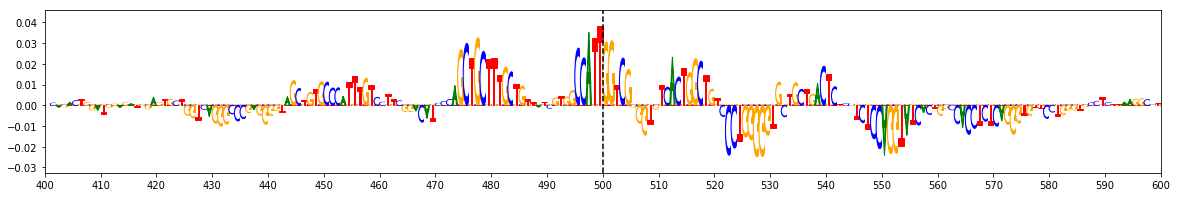

Noneffect Allele: C   ||  Explain Score: 0.4111   ||  Center / 200bp: 0.5377
Noneffect Sequence: CGTGGCCATCGGTCGGGGTG


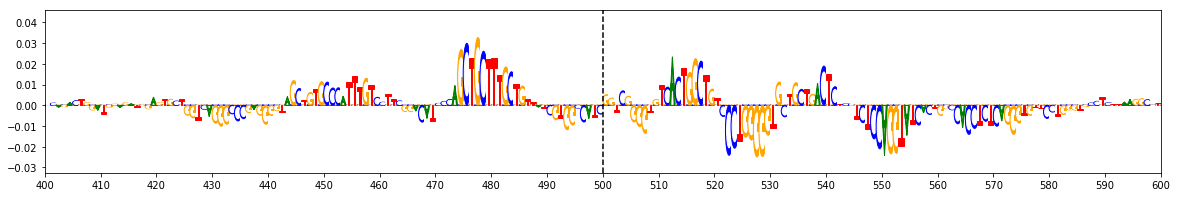

Allele Ratio : 1.6459   ||   Allele Difference : 0.3345  ||  ISM Score : 0.5312  ||  deltaSVM Score : 3.0406


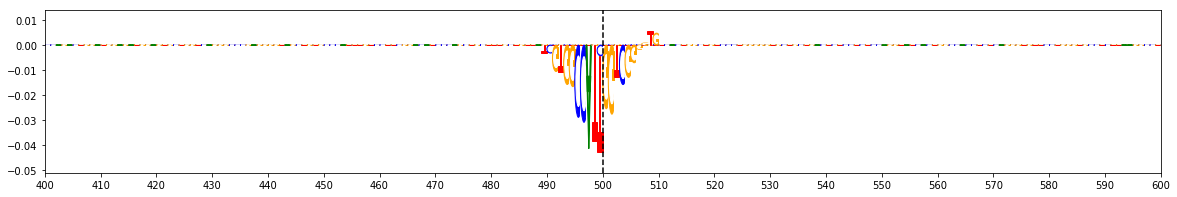


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs34034621   ||    chr19 : 45039212 - 45039213   ||    Locus: 191   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  4.19E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.4168   ||  Center / 200bp: 0.4767
Effect Sequence: CTGCTGCGTTCCGGCCCCGA


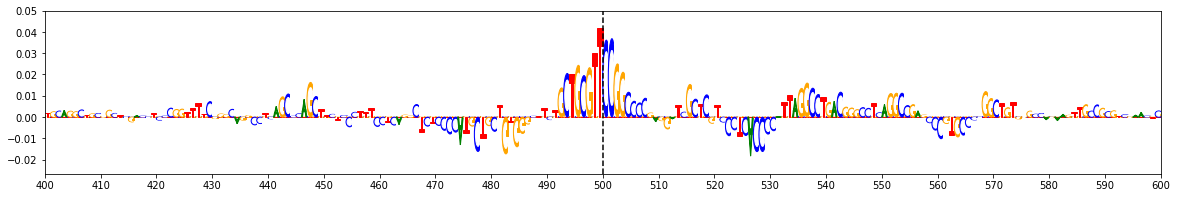

Noneffect Allele: C   ||  Explain Score: 0.2102   ||  Center / 200bp: 0.3152
Noneffect Sequence: CTGCTGCGTCCCGGCCCCGA


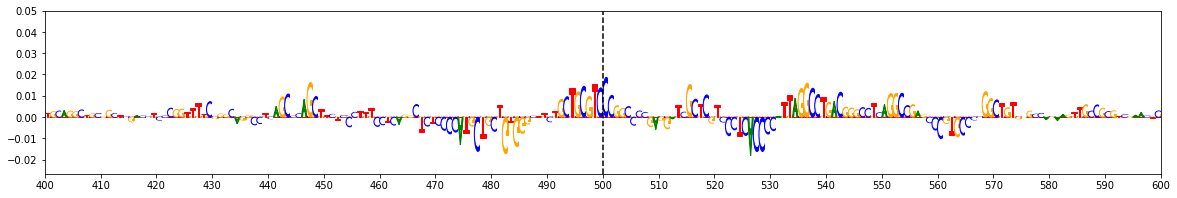

Allele Ratio : 1.9824   ||   Allele Difference : 0.2192  ||  ISM Score : 0.3469  ||  deltaSVM Score : 2.0033


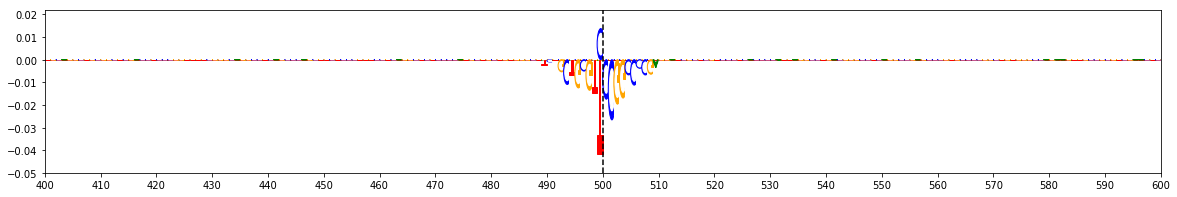


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs17854357   ||    chr11 : 65834088 - 65834089   ||    Locus: 23   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  3.26E-06

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.2683   ||  Center / 200bp: 0.4414
Effect Sequence: GGAGGTTGGCAAGGAGGGCA


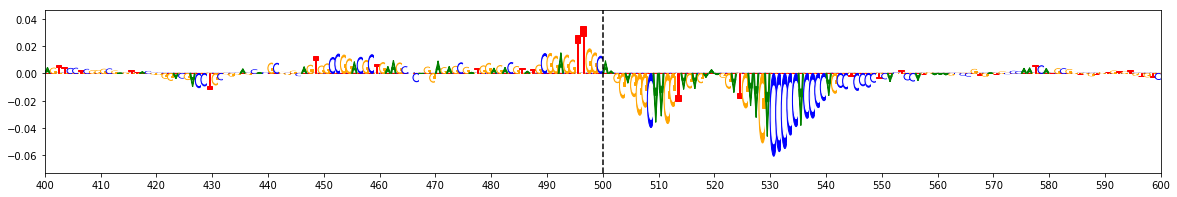

Noneffect Allele: G   ||  Explain Score: 0.1307   ||  Center / 200bp: 0.2779
Noneffect Sequence: GGAGGTTGGGAAGGAGGGCA


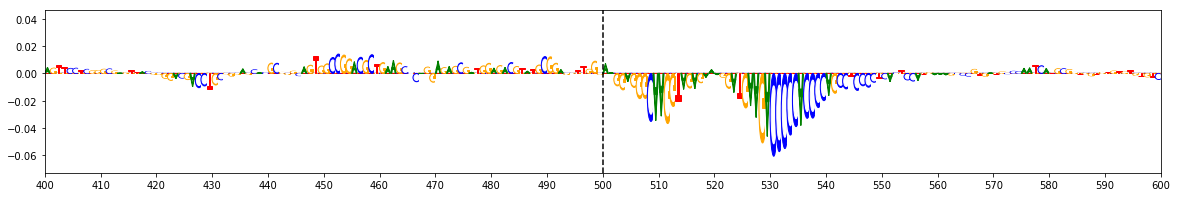

Allele Ratio : 2.0528   ||   Allele Difference : 0.1031  ||  ISM Score : 0.1748  ||  deltaSVM Score : 1.0123


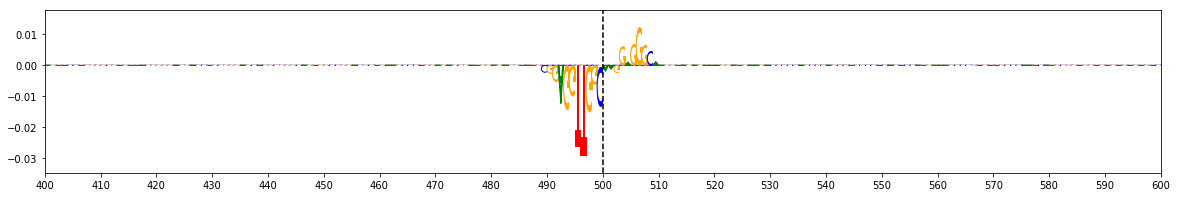


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs4771268   ||    chr13 : 97212766 - 97212767   ||    Locus: 35   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  1.06E-01

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.3413   ||  Center / 200bp: 0.4169
Effect Sequence: ATGTCTCTCTTTGTCGTCAA


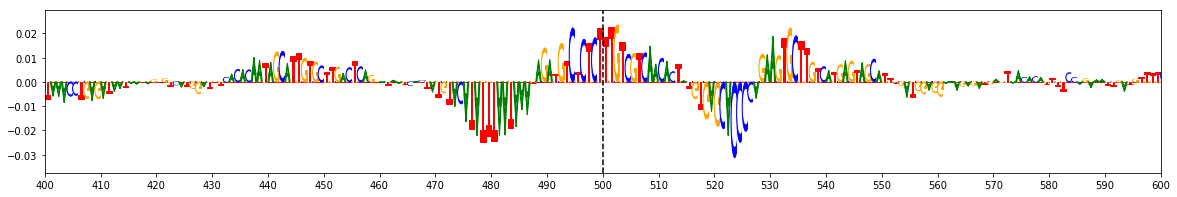

Noneffect Allele: C   ||  Explain Score: 0.1605   ||  Center / 200bp: 0.2517
Noneffect Sequence: ATGTCTCTCCTTGTCGTCAA


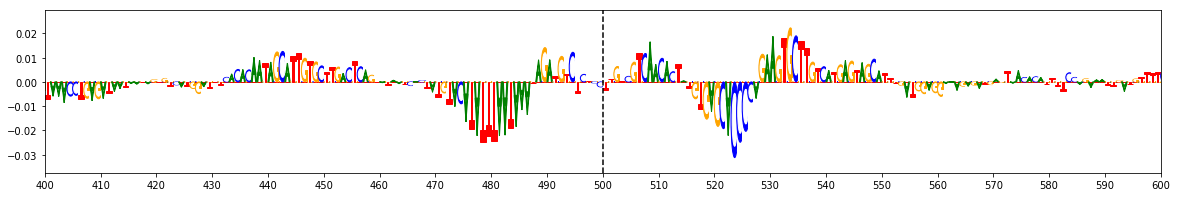

Allele Ratio : 2.1256   ||   Allele Difference : 0.1908  ||  ISM Score : 0.2972  ||  deltaSVM Score : 1.7043


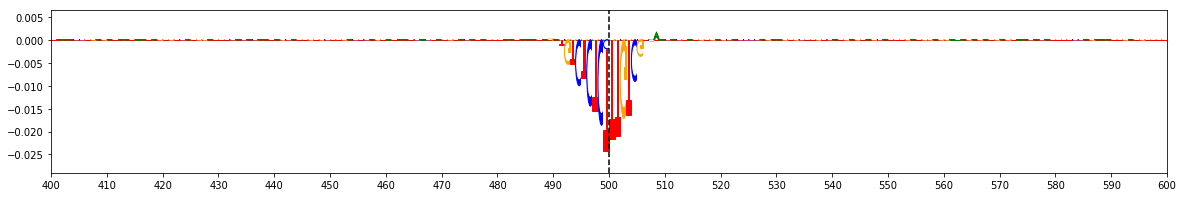


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs755934   ||    chr8 : 22599691 - 22599692   ||    Locus: 294   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  5.11E-02
Nalls_23andMe 		  5.11E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.5661   ||  Center / 200bp: 0.4833
Effect Sequence: GCGGCTGCATTGGCCGGGGC


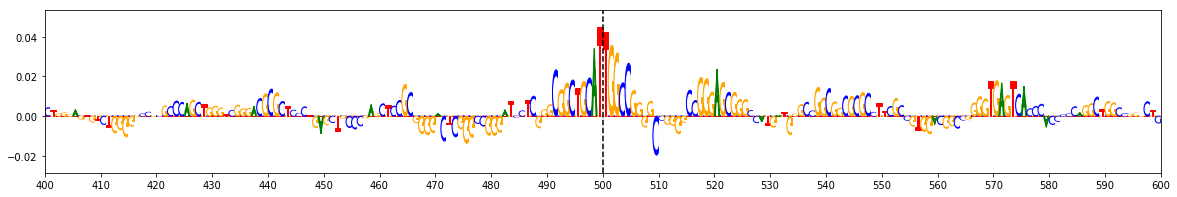

Noneffect Allele: G   ||  Explain Score: 0.3297   ||  Center / 200bp: 0.354
Noneffect Sequence: GCGGCTGCAGTGGCCGGGGC


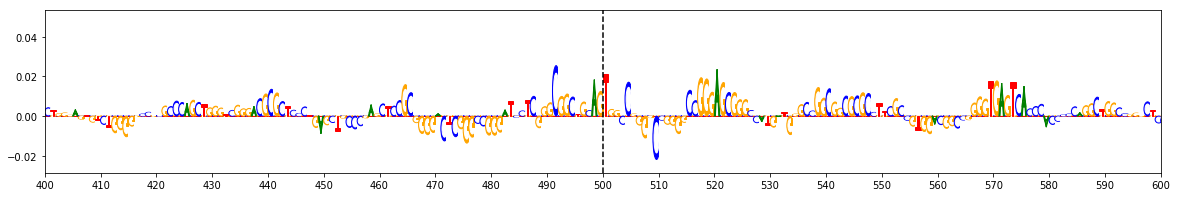

Allele Ratio : 1.7171   ||   Allele Difference : 0.2531  ||  ISM Score : 0.4034  ||  deltaSVM Score : 2.5208


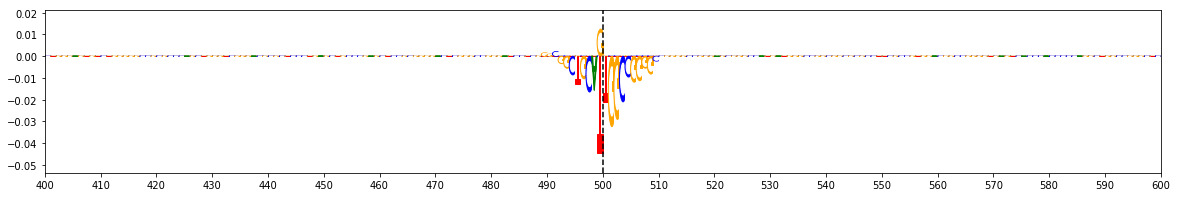


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62062770   ||    chr17 : 45942313 - 45942314   ||    Locus: 94   ||    IDR Peak: True

GWAS:
23andme_PD_hg38 		  3.67E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.9332   ||  Center / 200bp: 0.6363
Effect Sequence: CGTTTCTTCTTCCTTACAAA


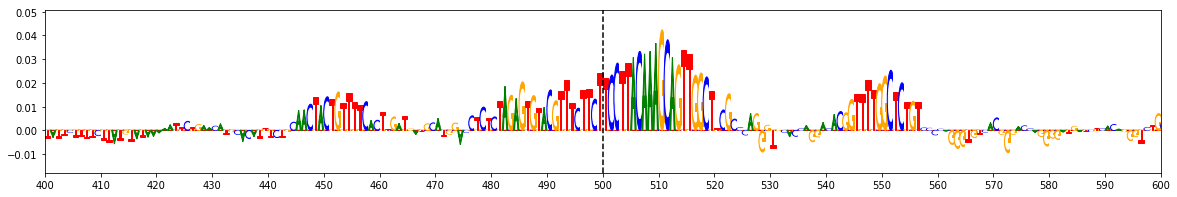

Noneffect Allele: C   ||  Explain Score: 0.7546   ||  Center / 200bp: 0.5859
Noneffect Sequence: CGTTTCTTCCTCCTTACAAA


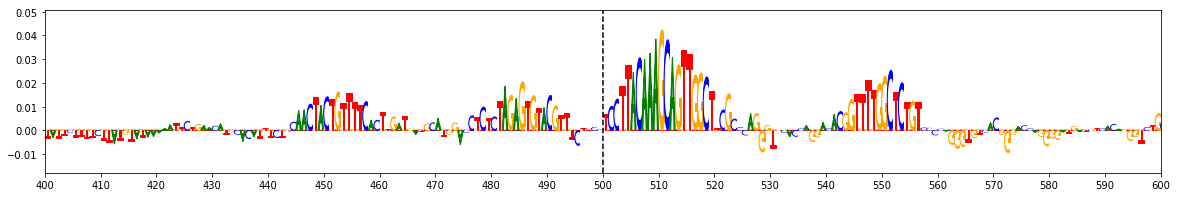

Allele Ratio : 1.2367   ||   Allele Difference : 0.1885  ||  ISM Score : 0.2938  ||  deltaSVM Score : 1.7005


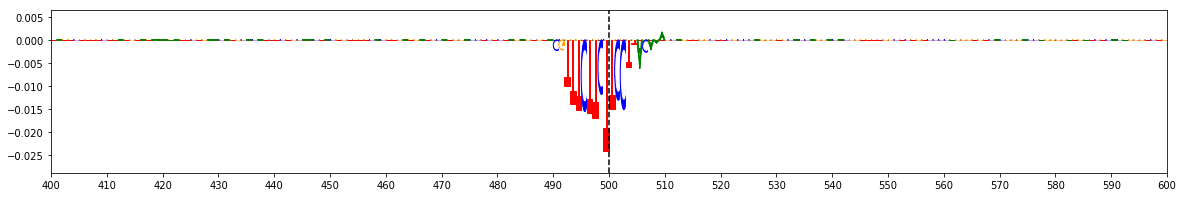


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs12073680   ||    chr1 : 232508907 - 232508908   ||    Locus: 6   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  3.90E-03
Nalls_23andMe 		  3.90E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.2069   ||  Center / 200bp: 0.5911
Effect Sequence: CTGGCCAACGCGGCGAAACC


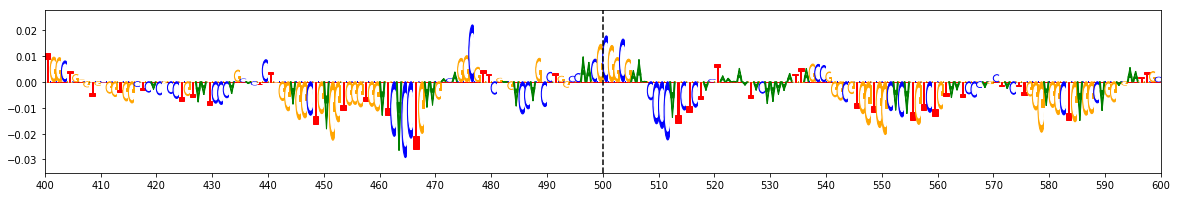

Noneffect Allele: A   ||  Explain Score: 0.1555   ||  Center / 200bp: 0.5211
Noneffect Sequence: CTGGCCAACACGGCGAAACC


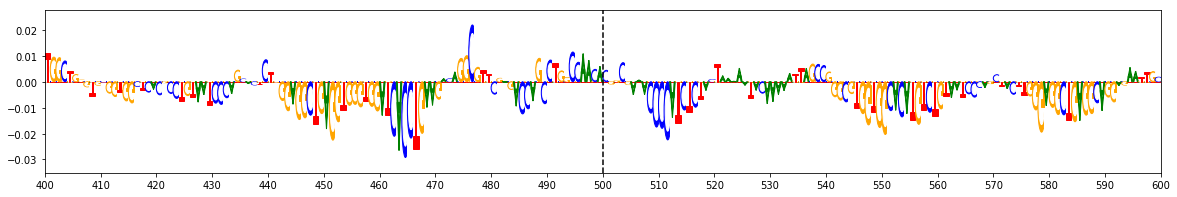

Allele Ratio : 1.3299   ||   Allele Difference : 0.0663  ||  ISM Score : 0.1055  ||  deltaSVM Score : 0.5877


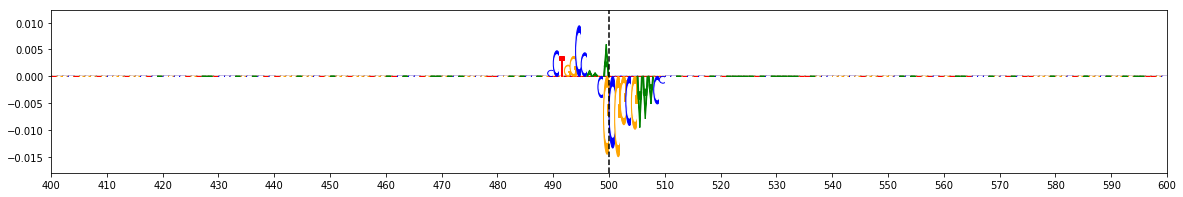


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs769446   ||    chr19 : 44905370 - 44905371   ||    Locus: 161   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  2.13E-09

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.2194   ||  Center / 200bp: 0.4094
Effect Sequence: GGCGTGAGCTACCGCCCCCA


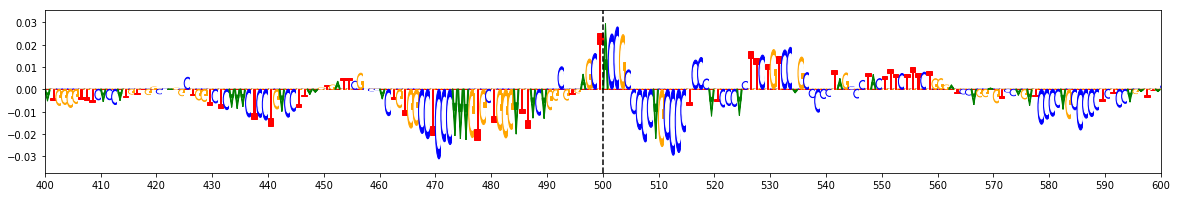

Noneffect Allele: C   ||  Explain Score: 0.1155   ||  Center / 200bp: 0.2676
Noneffect Sequence: GGCGTGAGCCACCGCCCCCA


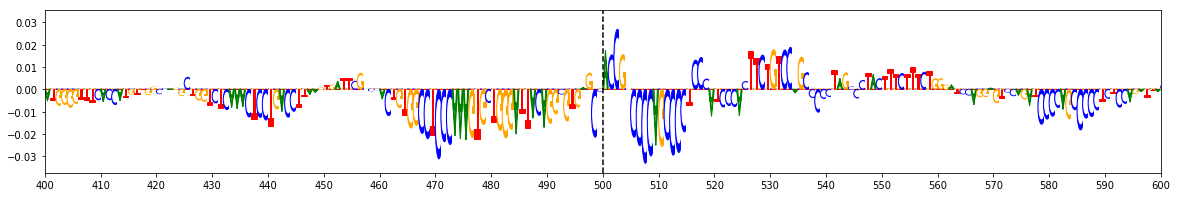

Allele Ratio : 1.8989   ||   Allele Difference : 0.2089  ||  ISM Score : 0.3322  ||  deltaSVM Score : 1.9616


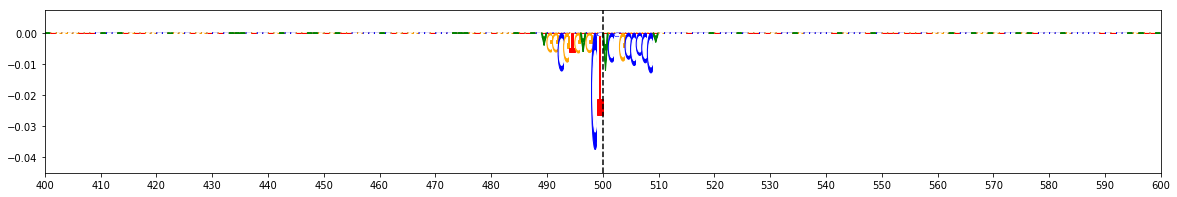


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs150820726   ||    chr19 : 44723890 - 44723891   ||    Locus: 142   ||    IDR Peak: True

GWAS:
Alzheimers_Jansen_2018 		  1.02E-11

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.5947   ||  Center / 200bp: 0.5806
Effect Sequence: AGCTGCCACTTGCAGGGTGA


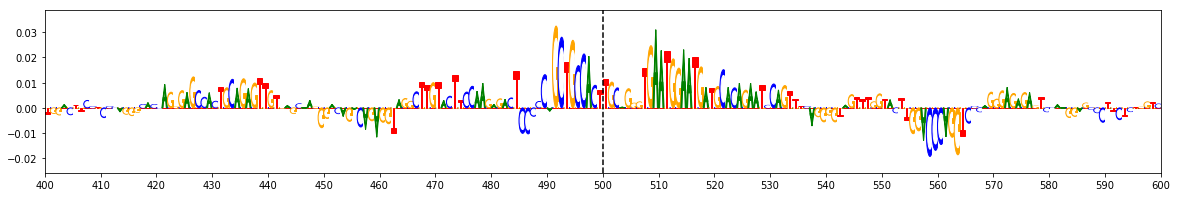

Noneffect Allele: A   ||  Explain Score: 0.4572   ||  Center / 200bp: 0.5151
Noneffect Sequence: AGCTGCCACATGCAGGGTGA


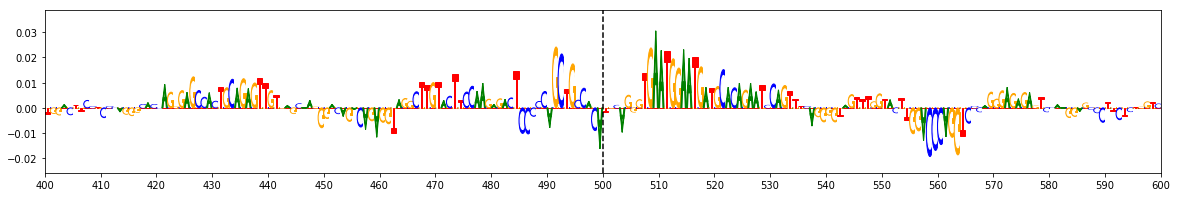

Allele Ratio : 1.3007   ||   Allele Difference : 0.1822  ||  ISM Score : 0.2862  ||  deltaSVM Score : 1.6663


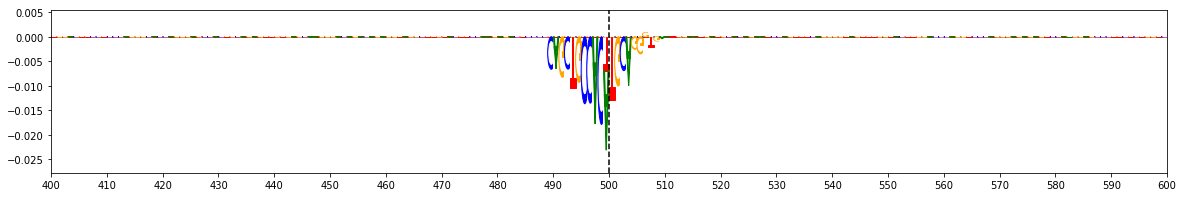


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2068397   ||    chr2 : 101762281 - 101762282   ||    Locus: 205   ||    IDR Peak: True

GWAS:
Chang_23andMe_Parkinsons 	  1.14E-03
Nalls_23andMe 		  1.14E-03

Coloc:  False

Effect Allele: C   ||  Explain Score: 0.2732   ||  Center / 200bp: 0.435
Effect Sequence: GGCAAATTGCCACACCTAGG


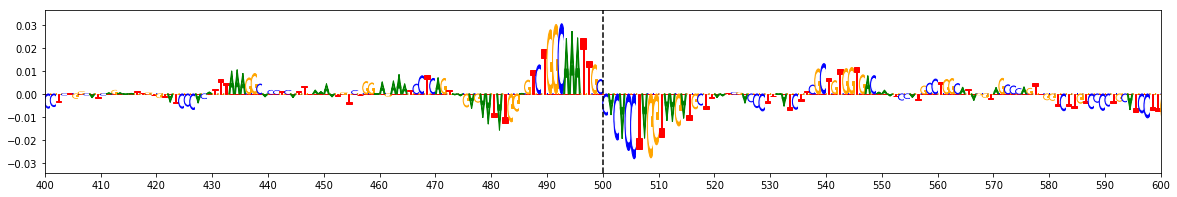

Noneffect Allele: A   ||  Explain Score: 0.1593   ||  Center / 200bp: 0.3084
Noneffect Sequence: GGCAAATTGACACACCTAGG


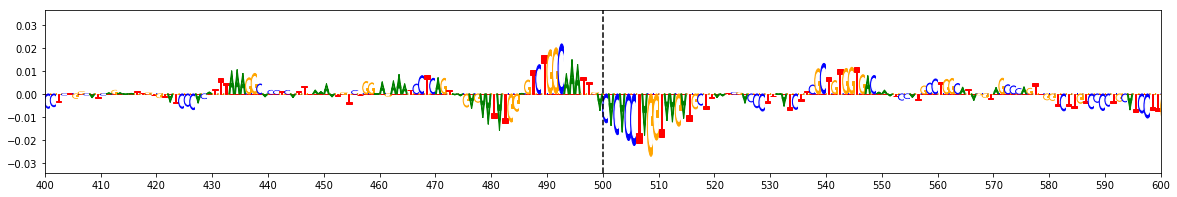

Allele Ratio : 1.7147   ||   Allele Difference : 0.1085  ||  ISM Score : 0.1699  ||  deltaSVM Score : 0.9427


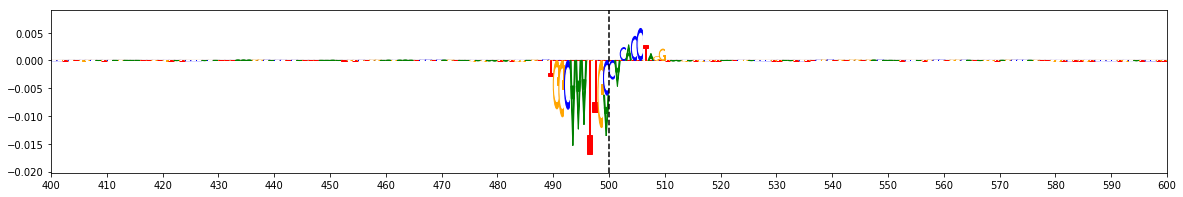


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs147889095   ||    chr1 : 226737182 - 226737183   ||    Locus: 5   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  1.77E-05
Nalls_23andMe 		  1.77E-05

Coloc:  False

Effect Allele: I   ||  Explain Score: 0.543   ||  Center / 200bp: 0.6013
Effect Sequence: ACTGCCGCTGCCACTGCCGC


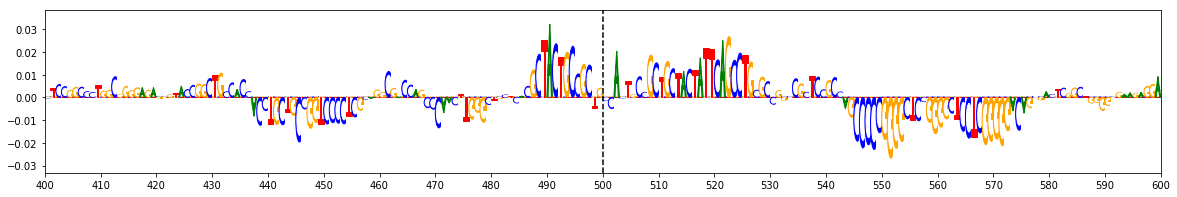

Noneffect Allele: D   ||  Explain Score: 0.438   ||  Center / 200bp: 0.4933
Noneffect Sequence: ACTGCCGCTGCTGCCGCTGC


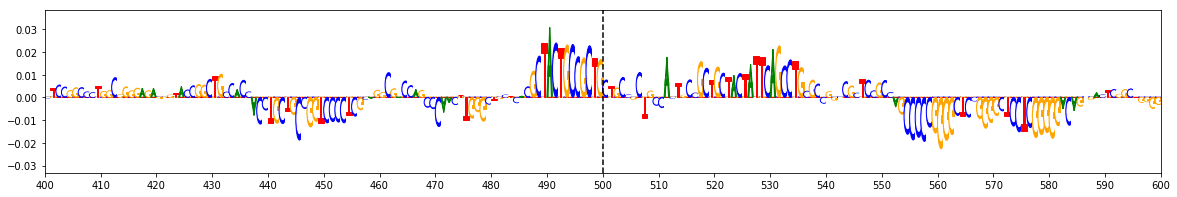

Allele Ratio : 1.2396   ||   Allele Difference : 0.1099  ||  ISM Score : 0.0791  ||  deltaSVM Score : 0.3469


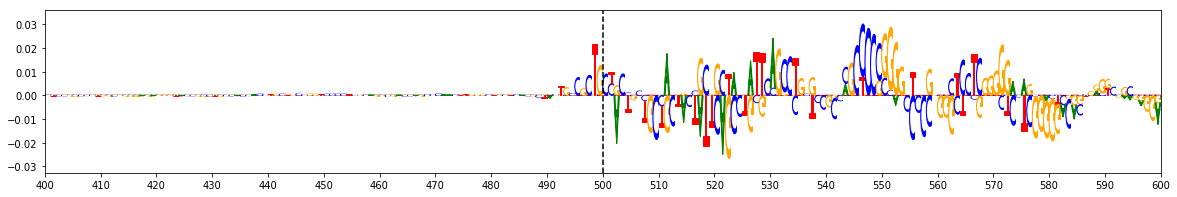


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs10913511   ||    chr1 : 171699810 - 171699811   ||    Locus: 1   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  6.51E-02

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.5517   ||  Center / 200bp: 0.485
Effect Sequence: ACTCTGGTTGCCTAAAGCAC


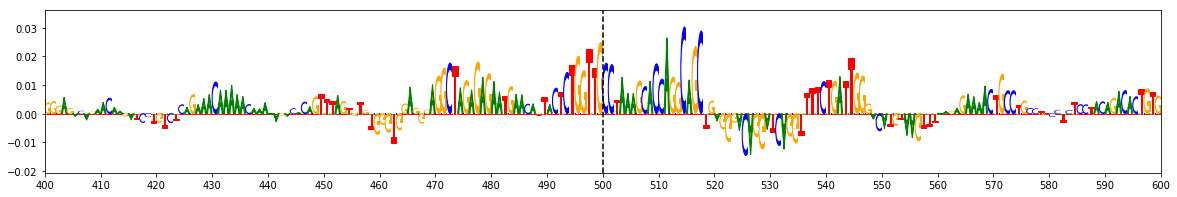

Noneffect Allele: A   ||  Explain Score: 0.3594   ||  Center / 200bp: 0.3802
Noneffect Sequence: ACTCTGGTTACCTAAAGCAC


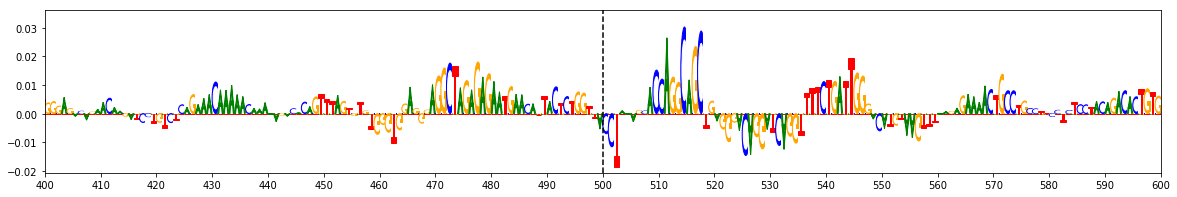

Allele Ratio : 1.5352   ||   Allele Difference : 0.2395  ||  ISM Score : 0.3751  ||  deltaSVM Score : 2.1526


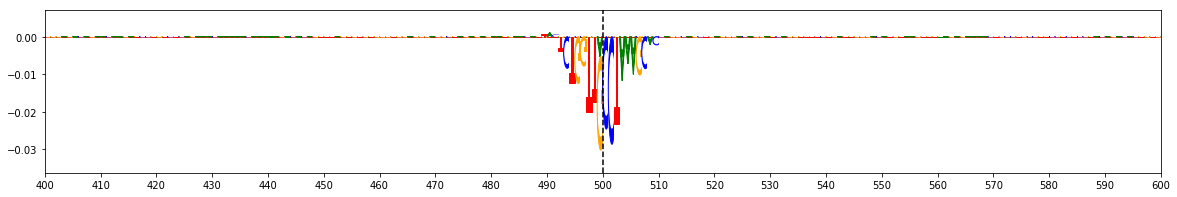


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs3758216   ||    chr9 : 17578708 - 17578709   ||    Locus: 303   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  1.23E-04
Nalls_23andMe 		  1.23E-04

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.9475   ||  Center / 200bp: 0.6156
Effect Sequence: AGAAGGCCAGTCTTTTTCAG


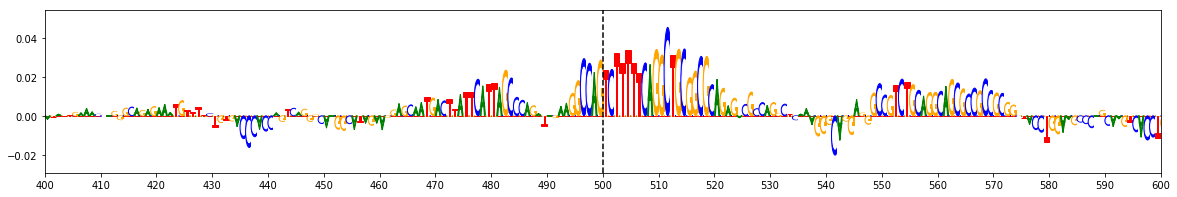

Noneffect Allele: C   ||  Explain Score: 0.7874   ||  Center / 200bp: 0.5708
Noneffect Sequence: AGAAGGCCACTCTTTTTCAG


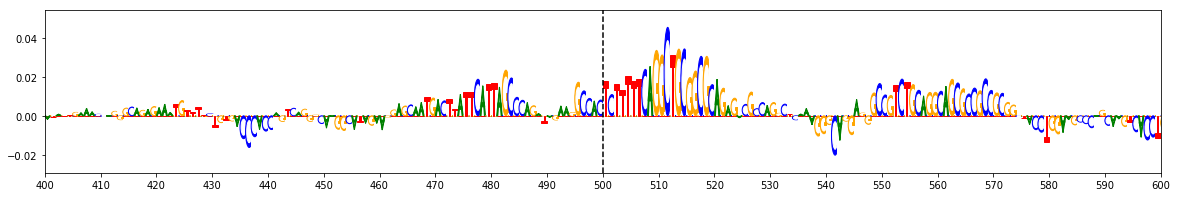

Allele Ratio : 1.2033   ||   Allele Difference : 0.1604  ||  ISM Score : 0.2517  ||  deltaSVM Score : 1.4325


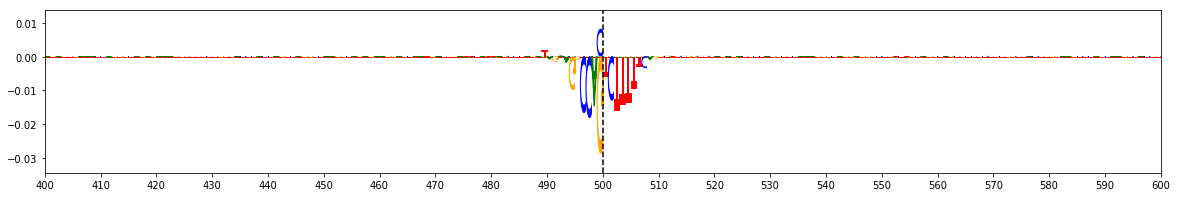


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs11540084   ||    chr19 : 44644039 - 44644040   ||    Locus: 140   ||    IDR Peak: True

GWAS:
Alzheimers_Kunkle_2019 		  5.12E-08
Alzheimers_Jansen_2018 		  2.18E-08

Coloc:  True

Effect Allele: T   ||  Explain Score: 1.0001   ||  Center / 200bp: 0.594
Effect Sequence: AGAGCGAGCTGGCGCCGGGA


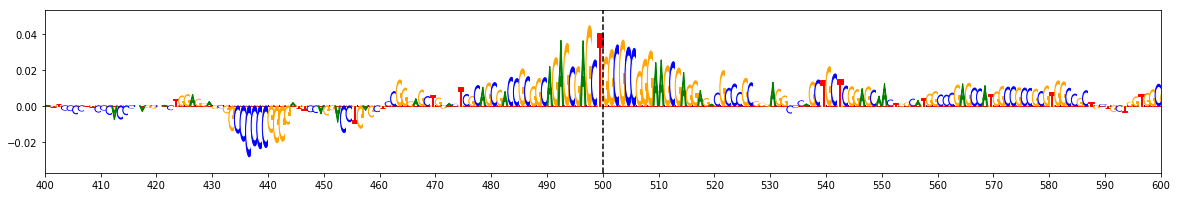

Noneffect Allele: G   ||  Explain Score: 0.8174   ||  Center / 200bp: 0.5451
Noneffect Sequence: AGAGCGAGCGGGCGCCGGGA


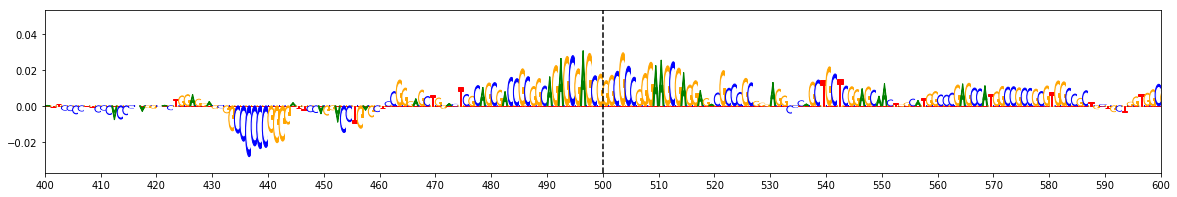

Allele Ratio : 1.2235   ||   Allele Difference : 0.1827  ||  ISM Score : 0.2884  ||  deltaSVM Score : 1.6772


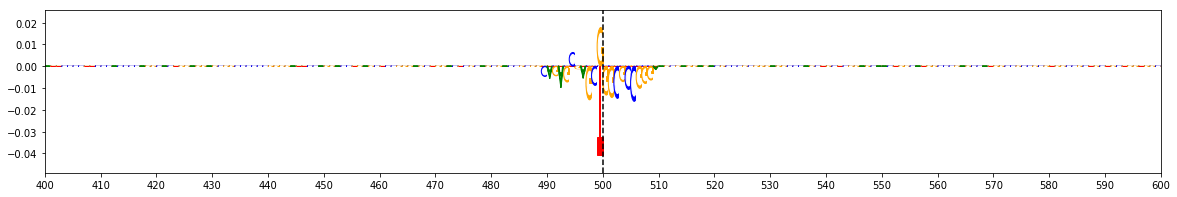


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs974291   ||    chr17 : 46073113 - 46073114   ||    Locus: 112   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  2.53E-22

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.6916   ||  Center / 200bp: 0.5426
Effect Sequence: TGTCCCTAGTGACTGCAAAA


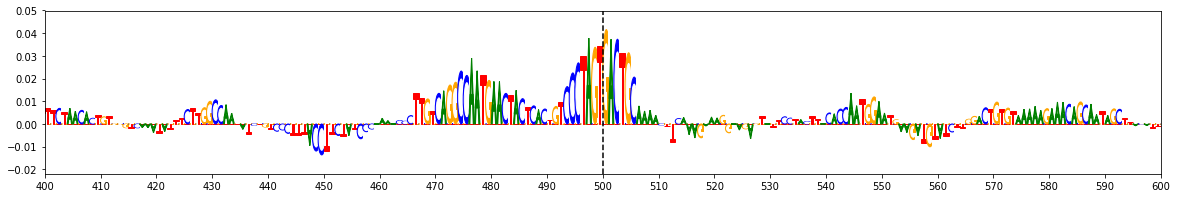

Noneffect Allele: A   ||  Explain Score: 0.5217   ||  Center / 200bp: 0.4724
Noneffect Sequence: TGTCCCTAGAGACTGCAAAA


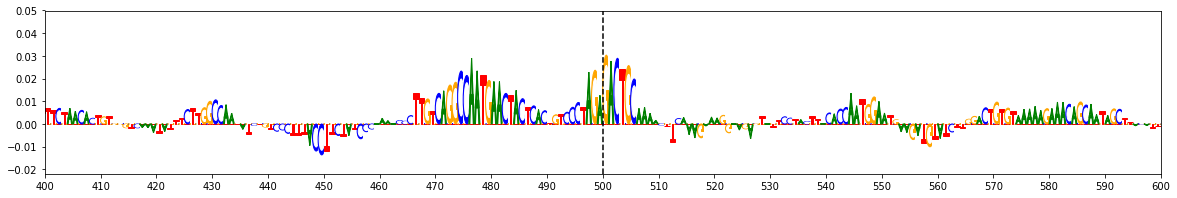

Allele Ratio : 1.3256   ||   Allele Difference : 0.1699  ||  ISM Score : 0.2642  ||  deltaSVM Score : 1.5246


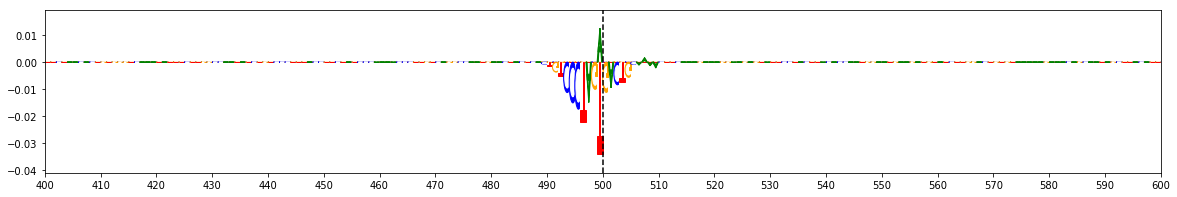


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs2032915   ||    chr16 : 31106091 - 31106092   ||    Locus: 56   ||    IDR Peak: False

GWAS:
Chang_23andMe_Parkinsons 	  3.22E-02

Coloc:  False

Effect Allele: T   ||  Explain Score: 0.6081   ||  Center / 200bp: 0.5192
Effect Sequence: CTGGCTGTATTCCAGGACGT


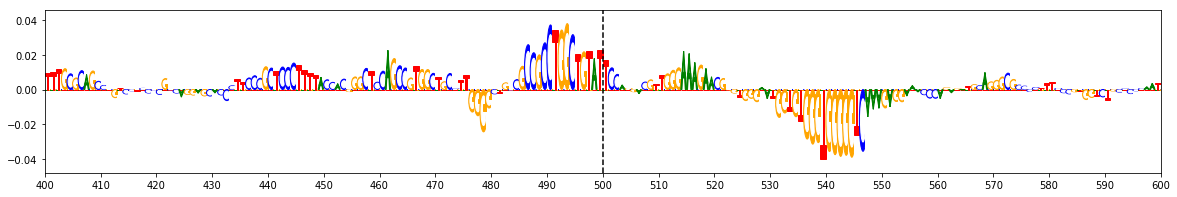

Noneffect Allele: C   ||  Explain Score: 0.4435   ||  Center / 200bp: 0.4407
Noneffect Sequence: CTGGCTGTACTCCAGGACGT


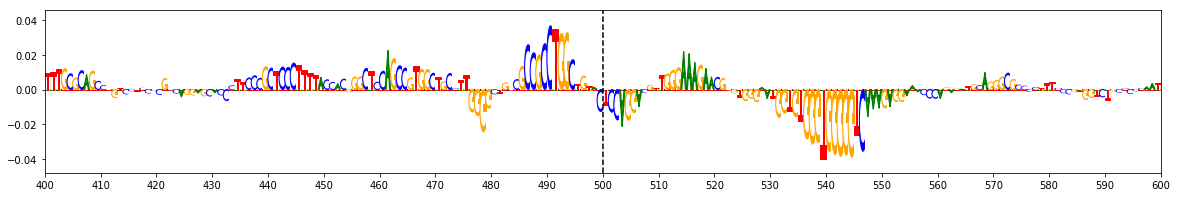

Allele Ratio : 1.3712   ||   Allele Difference : 0.2779  ||  ISM Score : 0.4377  ||  deltaSVM Score : 2.4964


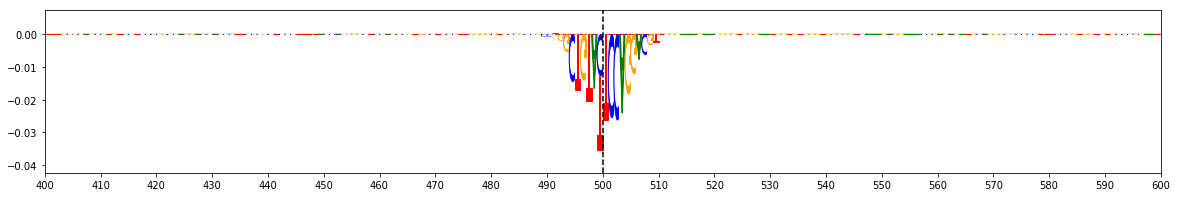


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs199523   ||    chr17 : 46771150 - 46771151   ||    Locus: 121   ||    IDR Peak: False

GWAS:
23andme_PD_hg38 		  9.49E-14

Coloc:  True

Effect Allele: C   ||  Explain Score: 0.6884   ||  Center / 200bp: 0.3455
Effect Sequence: GCCCTCCTGCGCCACCTACA


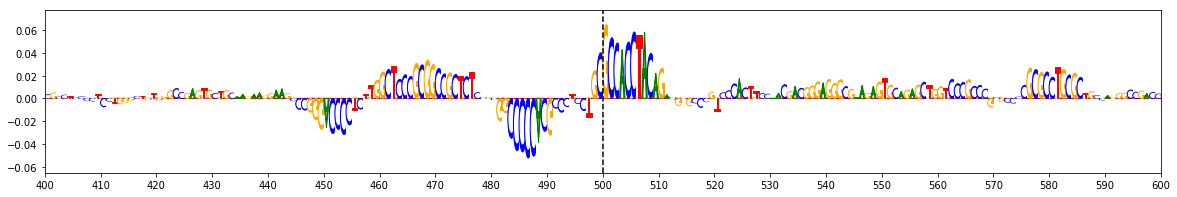

Noneffect Allele: A   ||  Explain Score: 0.3363   ||  Center / 200bp: 0.2047
Noneffect Sequence: GCCCTCCTGAGCCACCTACA


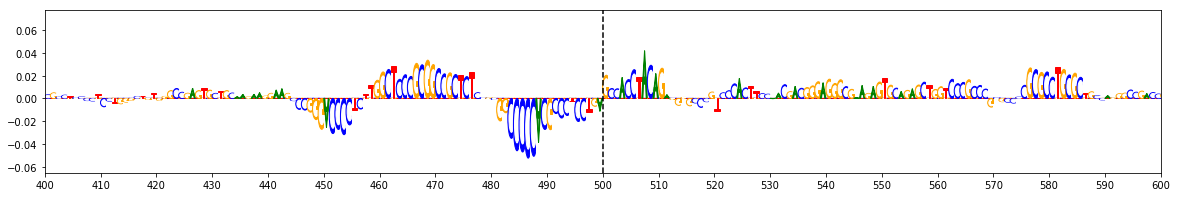

Allele Ratio : 2.0472   ||   Allele Difference : 0.4051  ||  ISM Score : 0.6424  ||  deltaSVM Score : 3.7096


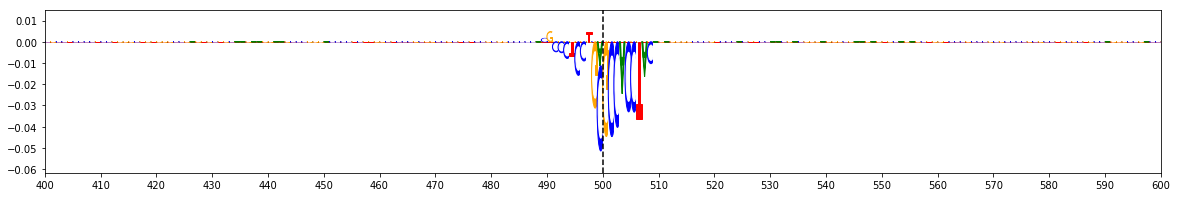


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs62171393   ||    chr2 : 134718389 - 134718390   ||    Locus: 221   ||    IDR Peak: False

GWAS:
Nalls_23andMe 		  9.02E-03

Coloc:  False

Effect Allele: G   ||  Explain Score: 0.8729   ||  Center / 200bp: 0.5272
Effect Sequence: CGGAGTGGCGCAGAAGCGCT


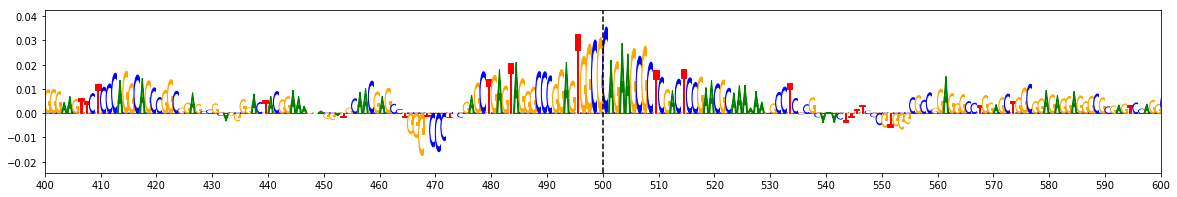

Noneffect Allele: C   ||  Explain Score: 0.6562   ||  Center / 200bp: 0.4559
Noneffect Sequence: CGGAGTGGCCCAGAAGCGCT


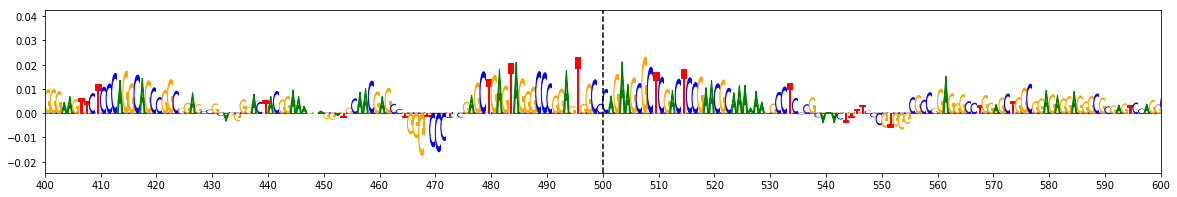

Allele Ratio : 1.3302   ||   Allele Difference : 0.2167  ||  ISM Score : 0.3386  ||  deltaSVM Score : 1.9642


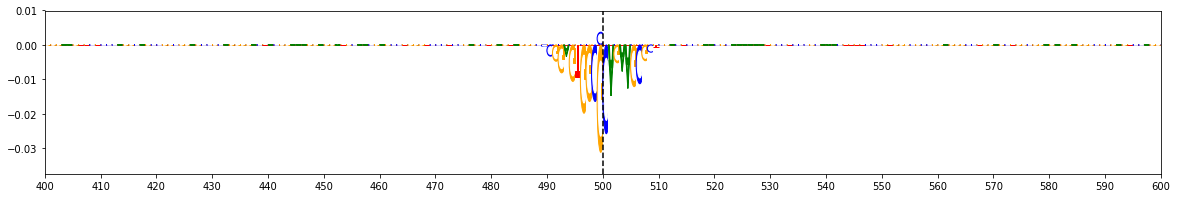


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


RSID: rs439401   ||    chr19 : 44911193 - 44911194   ||    Locus: 165   ||    IDR Peak: False

GWAS:
Alzheimers_Jansen_2018 		  1.76E-165
Alzheimers_Kunkle_2019 		  7.61E-128
Alzheimers_Lambert_2013 	  3.54E-79

Coloc:  True

Effect Allele: T   ||  Explain Score: 0.7358   ||  Center / 200bp: 0.6017
Effect Sequence: ACTCTCTTCTCCTCCCACCC


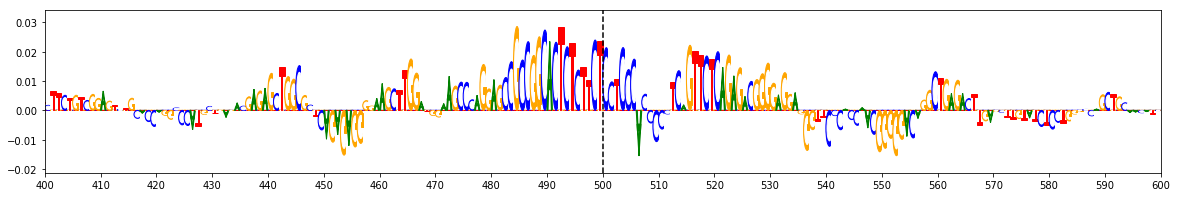

Noneffect Allele: C   ||  Explain Score: 0.6322   ||  Center / 200bp: 0.5656
Noneffect Sequence: ACTCTCTTCCCCTCCCACCC


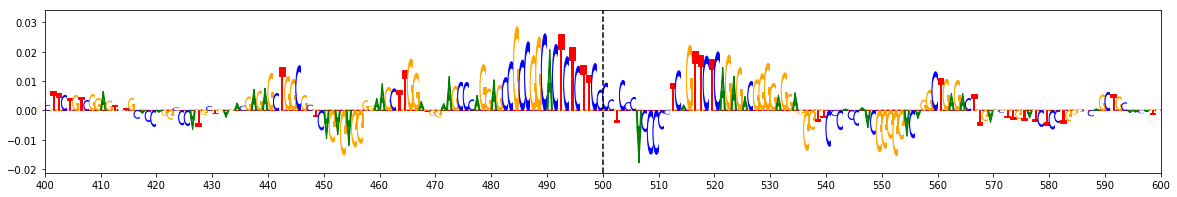

Allele Ratio : 1.1638   ||   Allele Difference : 0.132  ||  ISM Score : 0.206  ||  deltaSVM Score : 1.2135


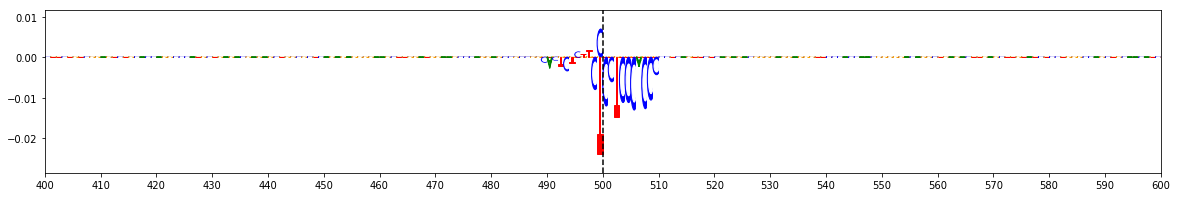


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [8]:
for idx in pos_snps.index[:20]:
    #for idx in [60]:
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], ':', pos_snps.at[idx, 'start'], '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', idx, '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    
    print()
    
    print('GWAS:')
    
    for i in pos_snps.at[idx, 'all_gwas']:
        entry = i.split(':')
        if 'Lambert' in entry[0] or 'Pankratz' in entry[0] or 'Chang' in entry[0]:
            print(entry[0], '\t', entry[1])
        else:
            print(entry[0], '\t\t', entry[1])
    
    print()
        
    print("Coloc: ", pos_snps.at[idx, 'coloc'])
    
    print()
    
    print('Effect Allele:', pos_snps.at[idx, 'effect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'effect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'effect_ratio'], 4))
    print('Effect Sequence:', effect_seqs[idx][490:510])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'], '  ||  Explain Score:', round(pos_snps.at[idx, 'noneffect_center'], 4), '  ||  Center / 200bp:', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
    print('Noneffect Sequence:', noneffect_seqs[idx][490:510])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('Allele Ratio :', round(pos_snps.at[idx, 'allele_ratio'], 4), '  ||   Allele Difference :', round(pos_snps.at[idx, 'allele_diff'], 4),
          ' ||  ISM Score :', round(pos_snps.at[idx, 'ism_score'], 4), ' ||  deltaSVM Score :', round(pos_snps.at[idx, 'delta_score'], 4))
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))
    
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()